In [1]:
%%capture
from time import time
!pip -q install ipytree~=0.2.1
!pip -q install matplotlib~=3.3.4

!pip uninstall -y s3fs fsspec maybe_sync real-simple-seismic
!pip install real-simple-seismic
!pip -q install numpy~=1.19.2
!pip -q install python-dotenv~=0.15.0
!pip -q install --upgrade awscli
!pip -q install --upgrade boto3
!pip -q install --upgrade git+https://github.com/dask/s3fs
    
!pip -q install s3fs #~=0.5.2
!pip -q install zarr~=2.6.1
#!pip3 install s3fs
#!pip -q install fsspec
!pip -q install seaborn
!pip -q install welly
#!pip -q install real-simple-seismic
!pip -q install segyio
!pip -q install pylops
!pip -q install scikit-learn
!pip -q install scikit-image
from math import floor, ceil

from rss.client import rssFromS3
from pandas import concat, IndexSlice, read_csv, read_json
import pandas as pd
from math import floor, ceil
from functools import reduce
from os.path import join
from sklearn.linear_model import LinearRegression
import scipy as sp
from scipy import signal

import segyio
import pylops
from sklearn.linear_model import LinearRegression, RANSACRegressor
import numpy as np
from rss.client import rssFromS3
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from os import getenv

from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
%%time
well_bucket = 's3://sagemaker-gitc2021/poseidon/wells/'
well_file = 'poseidon_geoml_training_wells.json.gz'

well_df = read_json(
    path_or_buf=well_bucket + well_file,
    compression='gzip',
)

well_df.set_index(['well_id', 'twt'], inplace=True)

well_bucket_blk = 's3://sagemaker-gitc2021/poseidon/wells/'
well_file_blk = 'poseidon_geoml_testing_wells_blank.json.gz'

well_df_blk = read_json(
    path_or_buf=well_bucket_blk + well_file_blk,
    compression='gzip',
)

well_df_blk.set_index(['well_id', 'twt'], inplace=True)
well_df = pd.concat([well_df, well_df_blk])

'''
Get well names and separate `DataFrame` per well, and put in a dictionary.
We also build inline / crossline ranges (min/max) for each well here. This will give us the range to
query from the seismic data.
'''
well_names = well_df.index.levels[0].to_list()
num_wells = len(well_names)
print(num_wells)

wells = {}
il_ranges = {}
xl_ranges = {}
for well_name in well_names:
    well = well_df.loc[well_name]
    well_ils_xls = well[['inline', 'xline']]
    il_xl_min = well_ils_xls.min()
    il_xl_max = well_ils_xls.max()

    wells[well_name] = well
    il_ranges[well_name] = floor(il_xl_min[0]), ceil(il_xl_max[0])
    xl_ranges[well_name] = floor(il_xl_min[1]), ceil(il_xl_max[1])

#print(wells[well_name])
wells['well_07'].head()

8
CPU times: user 383 ms, sys: 45.4 ms, total: 428 ms
Wall time: 914 ms


tvdss     inline      xline  gamma  rshal  rdeep  nphi  cal  rhob  \
twt                                                                         
2700.0    NaN  3256.5233  1389.3571    NaN    NaN    NaN   NaN  NaN   NaN   
2700.5    NaN  3256.5234  1389.3559    NaN    NaN    NaN   NaN  NaN   NaN   
2701.0    NaN  3256.5236  1389.3547    NaN    NaN    NaN   NaN  NaN   NaN   
2701.5    NaN  3256.5237  1389.3535    NaN    NaN    NaN   NaN  NaN   NaN   
2702.0    NaN  3256.5238  1389.3523    NaN    NaN    NaN   NaN  NaN   NaN   

        dtc  dts  p_impedance  s_impedance  
twt                                         
2700.0  NaN  NaN          NaN          NaN  
2700.5  NaN  NaN          NaN          NaN  
2701.0  NaN  NaN          NaN          NaN  
2701.5  NaN  NaN          NaN          NaN  
2702.0  NaN  NaN          NaN          NaN

In [3]:
%%time

'''
Now, we need to extract seismic values around the wellbore. Let's start with
mounting `real-simple-seismic` volumes of interest so we can query later.
**Poseidon data vertical sampling is between 0 and 6,000 milliseconds.**
**Seismic is sampled every 4 ms, and velocities are sampled every 10 ms.**
'''
seismic_bucket = 's3://sagemaker-gitc2021/poseidon/seismic/rss/'

seismic_files = [
    'psdn11_TbsdmF_Near_Nov_11_32bit',  # near angle stack (AVO)
    'psdn11_TbsdmF_Mid_Nov_11_32bit',  # mid angle stack (AVO)
    'psdn11_TbsdmF_Far_Nov_11_32bit',  # far angle stack (AVO)
    'Final_PSDM_intVel_gridded_D2T_10ms',  # PSDM interval velocities in time
]

'''
We loop through all files, and make connections to all four.
This takes about a minute.
The handles are later used for querying.
'''
rss_handles = []
for seismic_file in seismic_files:
    current_rss = rssFromS3(filename=seismic_bucket + seismic_file, client_kwargs={})

    rss_handles.append(current_rss)

        
from itertools import product
import numpy as np

# let's have nicer names for seismic data
seismic_names = ('near', 'mid', 'far', 'velocity')
seismic_names_just = ('near', 'mid', 'far')
velocity_names_just = ('velocity')
well_seismic = {}
for well in wells.keys():
    il_min, il_max = il_ranges[well]
    xl_min, xl_max = xl_ranges[well]

    ils = range(il_min, il_max + 1, 1)  # inline increment is 1
    xls = range(xl_min, xl_max + 1, 1)  # xline increment is 1

    # Use product to have all il/xl pairs within our ranges
    ilxl_pairs = list(product(ils, xls))

    cube_data = {}
    # In rss, for minicube extraction we query trace by trace.
    for rss_handle, seismic_name in zip(rss_handles, seismic_names):
        tmp = []
        for trace_ilxl in ilxl_pairs:
            tmp.append(rss_handle.trace(*trace_ilxl)[0])  # rss returns values and a live mask, we don't need the mask now

        # Traces aren't in a "cube" shape, they come sequential. So we reshape!
        cube_data[seismic_name] = np.asarray(tmp).reshape(len(ils), len(xls), -1)

    well_seismic[well] = cube_data

print(len(well_seismic))

Connection complete.
8
CPU times: user 30.7 s, sys: 4.18 s, total: 34.9 s
Wall time: 1min 40s


In [4]:
with open('pseudo_refl.npy', 'rb') as f:
    temp = np.load(f, allow_pickle=True)

pseudo_refl = temp[0]
stack_data = temp[1]
wavelet = temp[2]
angle_time = temp[3]
print(len(pseudo_refl))

print(len(well_seismic))

3
8


## Section 1. Feature Engineering

Let's begin with loading some libraries

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sns.set(style="darkgrid")

# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras as k

### Well Seismic composite

In [6]:
## Getting the well seismic composite
first_seismic = seismic_names[0]
print(first_seismic)
tmpp = pseudo_refl[0]
df = pd.DataFrame(np.mean((np.mean(well_seismic['well_01'][first_seismic],axis=1)), axis=0), 
                                        columns=['well_01_' + first_seismic + '_composite'])
df = pd.DataFrame(tmpp[0,:], columns=['well_01_' + first_seismic + '_composite_refl'])
ict_seis = 0
for seismic_name in seismic_names_just:
    tmpp = pseudo_refl[ict_seis]
    ict_well = 0
    for well in wells.keys():
        df[well + '_' + seismic_name + '_composite'] = np.mean((np.mean(well_seismic[well][seismic_name],axis=1)), axis=0)

        df[well + '_' + seismic_name + '_composite_refl'] = tmpp[ict_well,:]
        ict_well += 1
    ict_seis += 1

df.head()

near


well_01_near_composite_refl  well_01_near_composite  \
0                   505.305064               -2.459141   
1                   505.305064               -2.459141   
2                   505.305064               -2.459141   
3                   505.305064               -2.459141   
4                   505.305064               -2.459141   

   well_07_near_composite  well_07_near_composite_refl  \
0               -3.686249                   249.568409   
1               -3.686249                   249.568409   
2               -3.686249                   249.568409   
3               -3.686249                   249.568409   
4               -3.686249                   249.568409   

   well_11_near_composite  well_11_near_composite_refl  \
0               -0.359645                  -859.133511   
1               -0.359645                  -859.133511   
2               -0.359645                  -859.133511   
3               -0.359645                  -859.133511   
4               -0.359645                  -859.133511   

   well_13_near_composite  well_13_near_composite_refl  \
0               -1.837291                  1290.684319   
1               -1.837291                  1290.684319   
2               -1.837291                  1290.684319   
3               -1.837291                  1290.684319   
4               -1.837291                  1290.684319   

   well_21_near_composite  well_21_near_composite_refl  ...  \
0               -3.358005                  1569.076597  ...   
1               -3.358005                  1569.076597  ...   
2               -3.358005                  1569.076597  ...   
3               -3.358005                  1569.076597  ...   
4               -3.358005                  1569.076597  ...   

   well_13_far_composite  well_13_far_composite_refl  well_21_far_composite  \
0              -1.478535                 1290.684319               -1.54652   
1              -1.478535                 1290.684319               -1.54652   
2              -1.478535                 1290.684319               -1.54652   
3              -1.478535                 1290.684319               -1.54652   
4              -1.478535                 1290.684319               -1.54652   

   well_21_far_composite_refl  well_25_far_composite  \
0                 1569.076597              -1.273305   
1                 1569.076597              -1.273305   
2                 1569.076597              -1.273305   
3                 1569.076597              -1.273305   
4                 1569.076597              -1.273305   

   well_25_far_composite_refl  well_27_far_composite  \
0                -1273.271254              -0.613544   
1                -1273.271254              -0.613544   
2                -1273.271254              -0.613544   
3                -1273.271254              -0.613544   
4                -1273.271254              -0.613544   

   well_27_far_composite_refl  well_33_far_composite  \
0                  574.228128               -1.94823   
1                  574.228128               -1.94823   
2                  574.228128               -1.94823   
3                  574.228128               -1.94823   
4                  574.228128               -1.94823   

   well_33_far_composite_refl  
0                 3570.759967  
1                 3570.759967  
2                 3570.759967  
3                 3570.759967  
4                 3570.759967  

[5 rows x 48 columns]

Let's plot all of the composites for a quick QC 

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


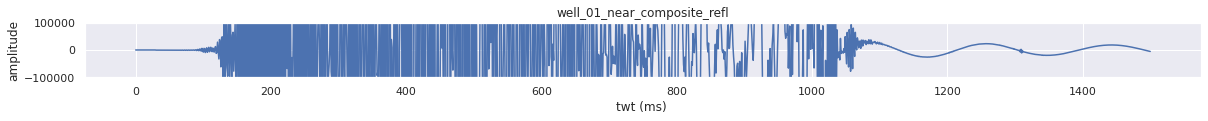

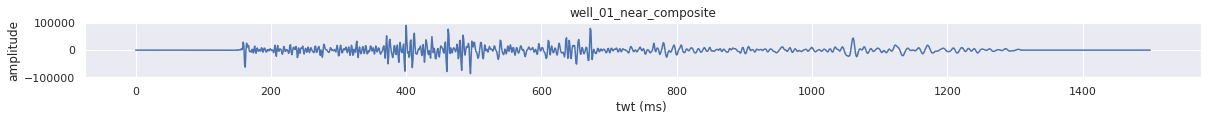

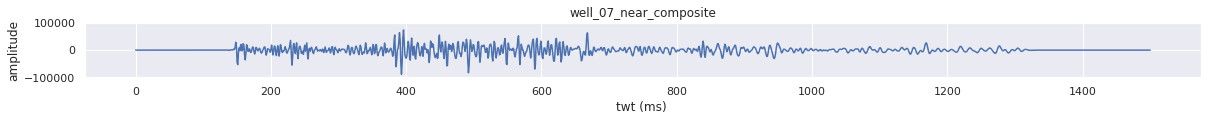

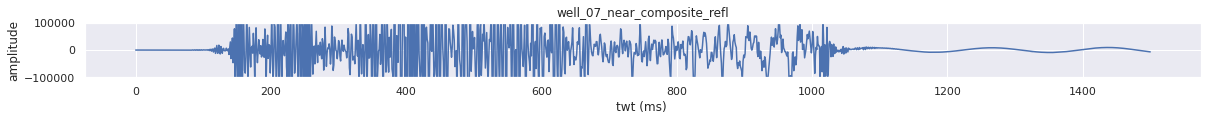

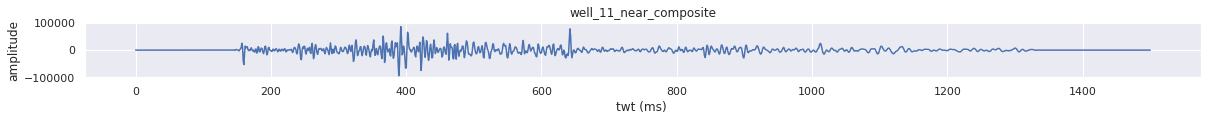

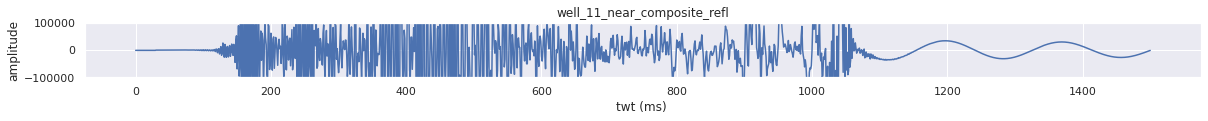

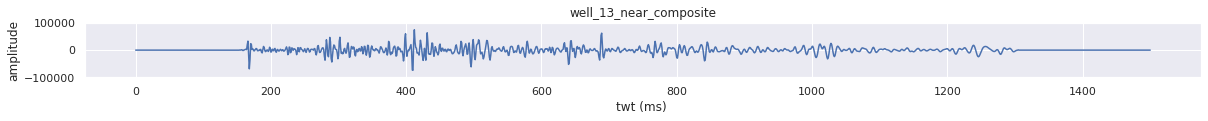

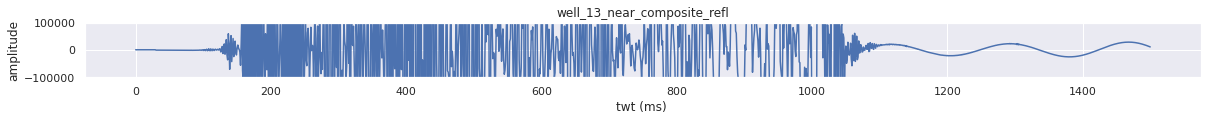

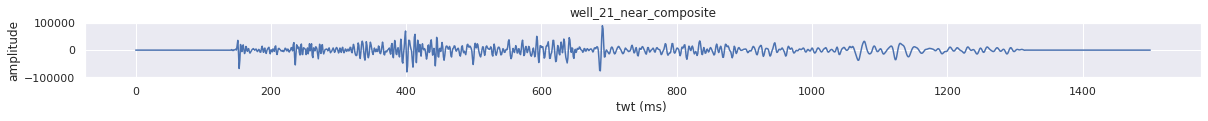

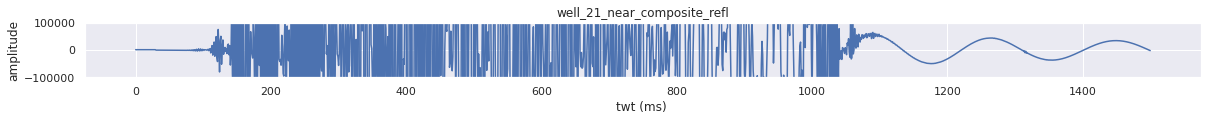

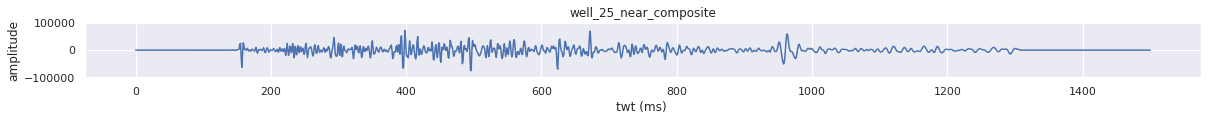

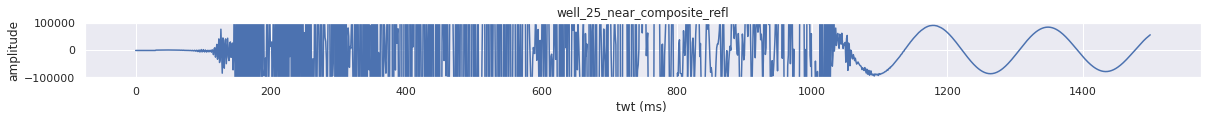

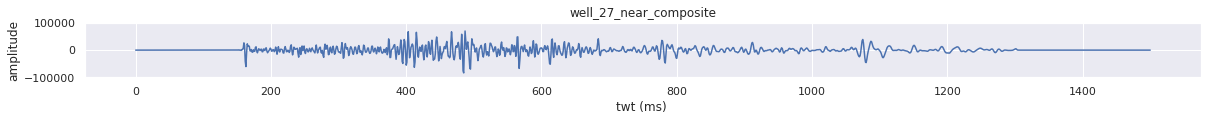

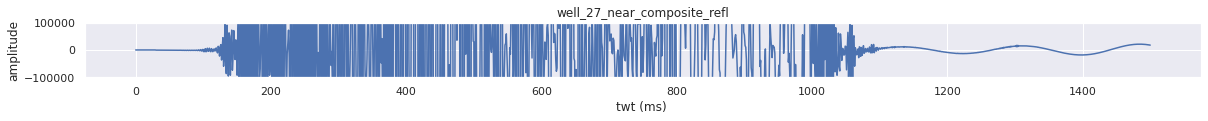

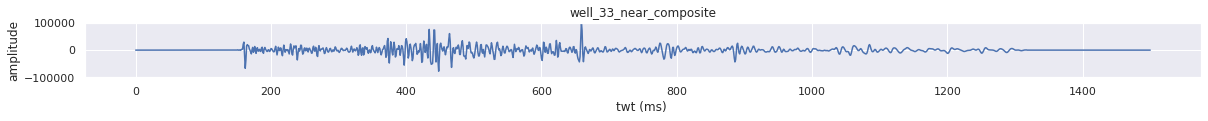

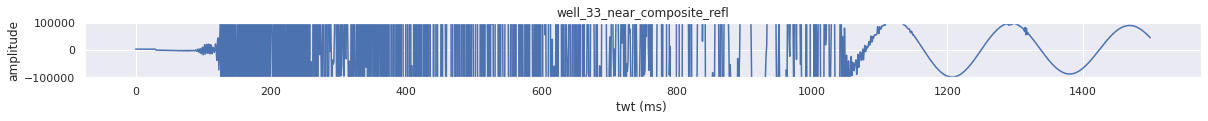

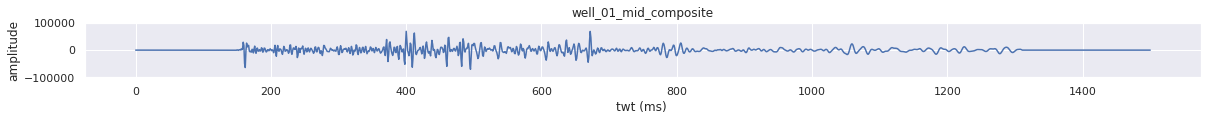

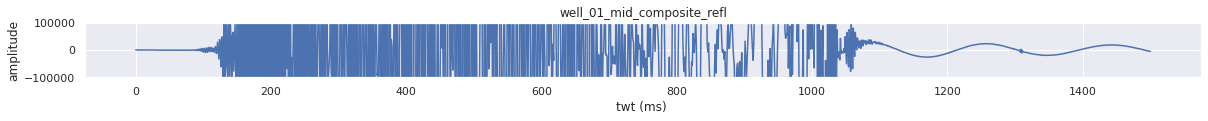

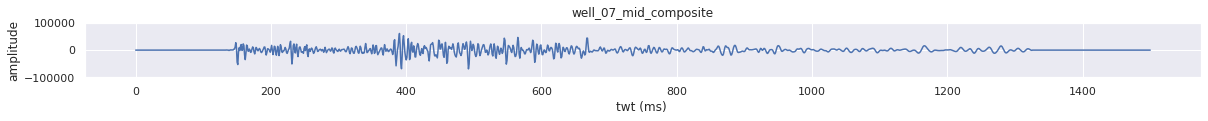

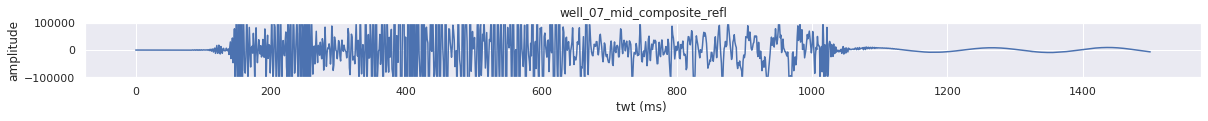

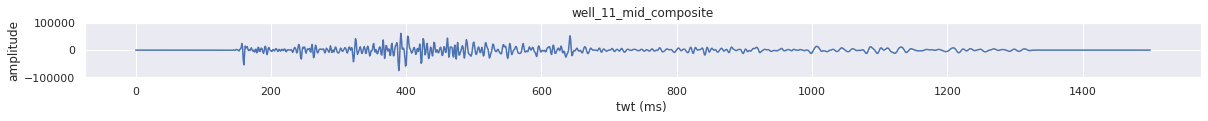

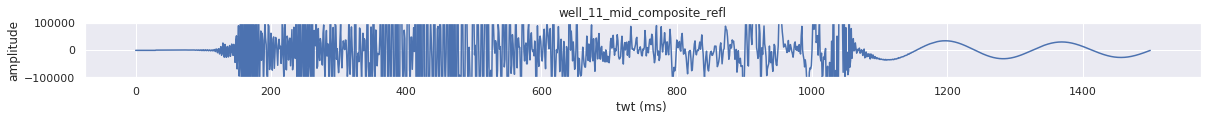

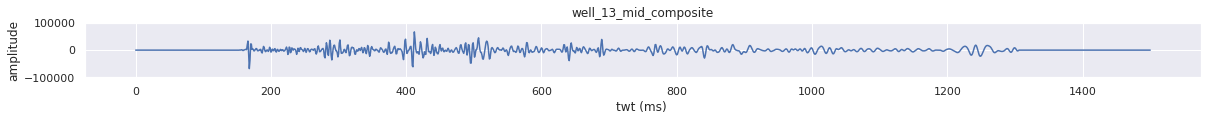

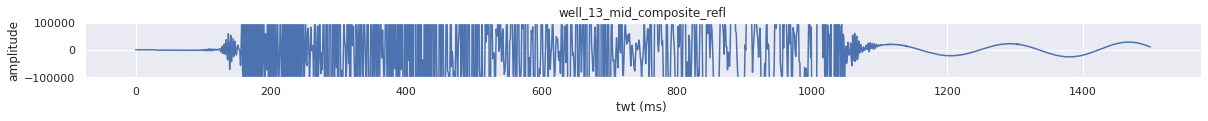

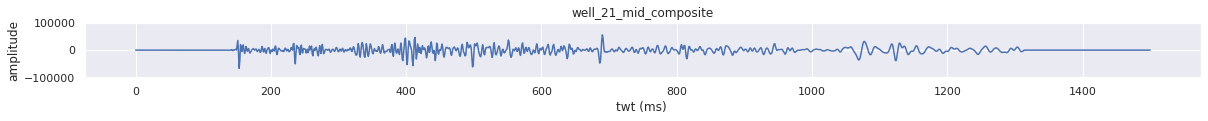

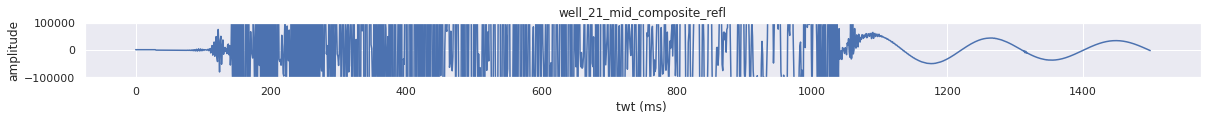

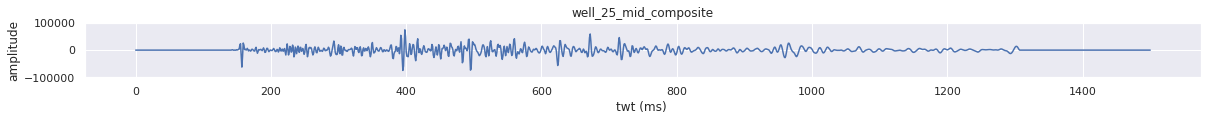

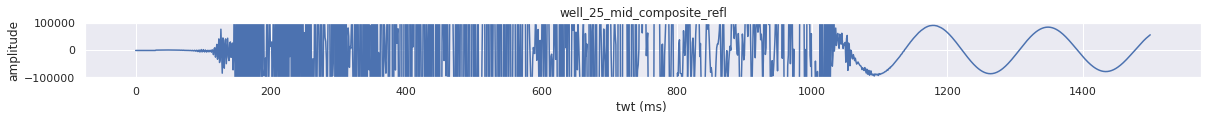

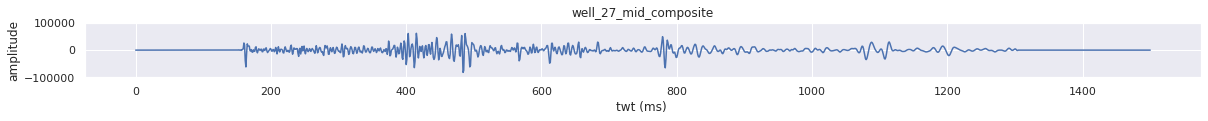

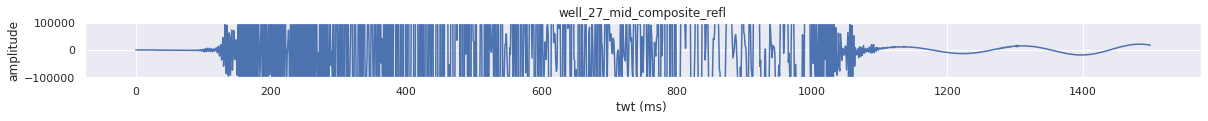

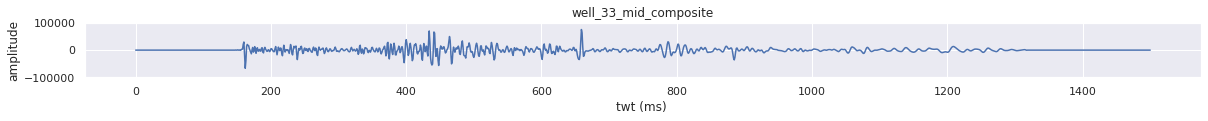

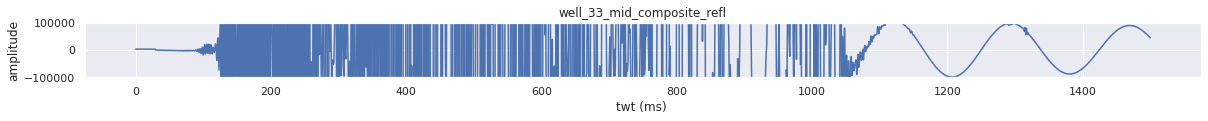

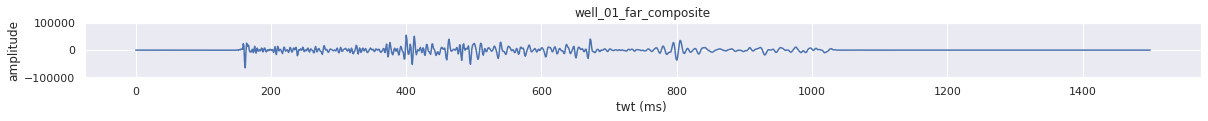

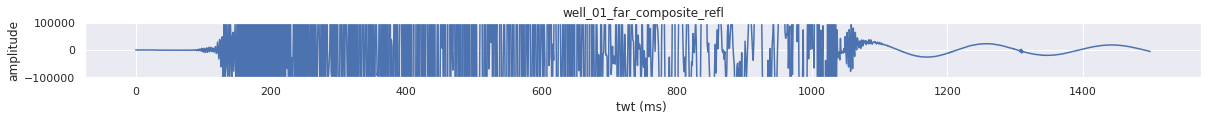

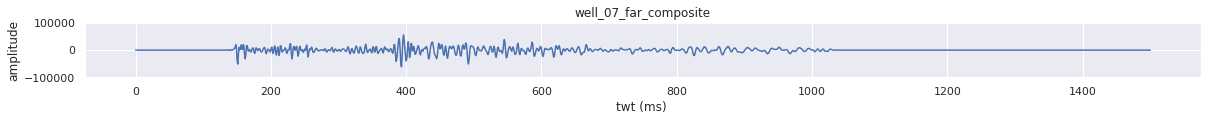

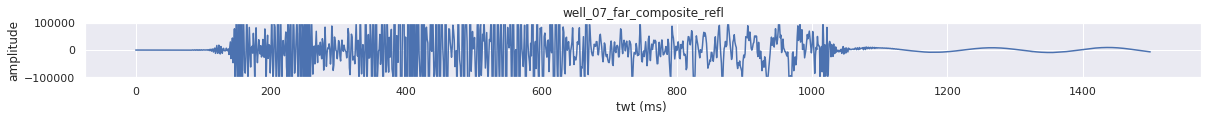

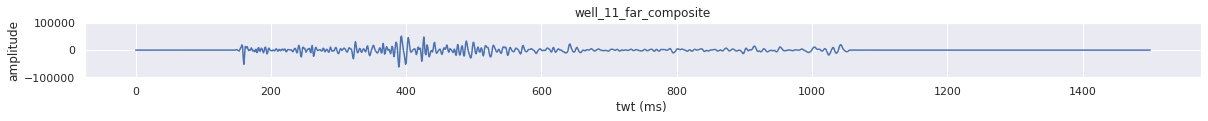

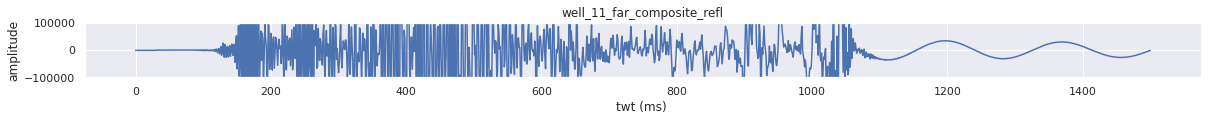

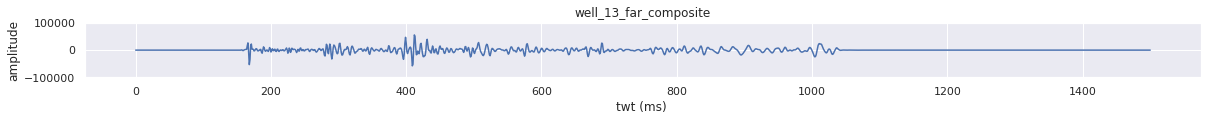

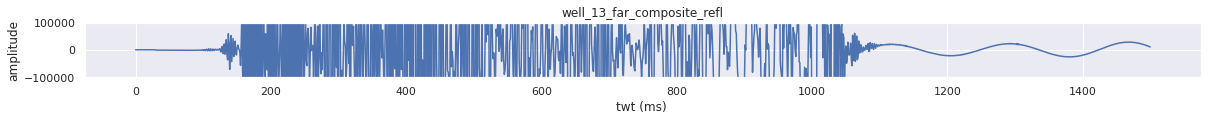

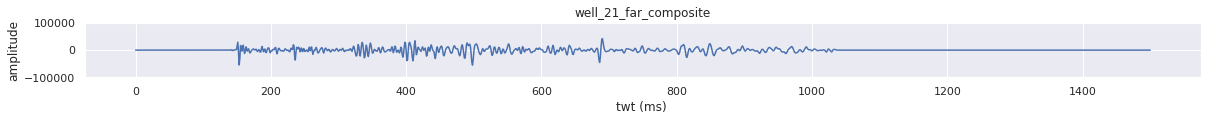

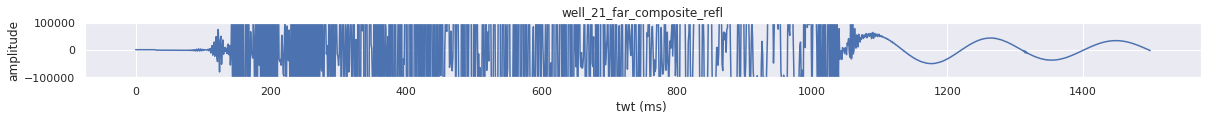

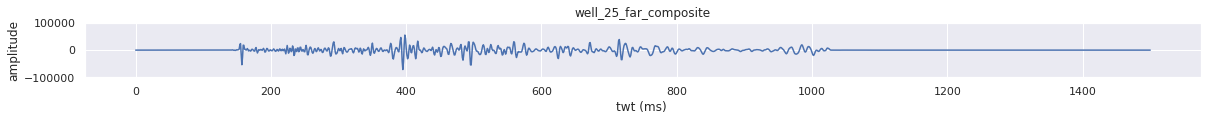

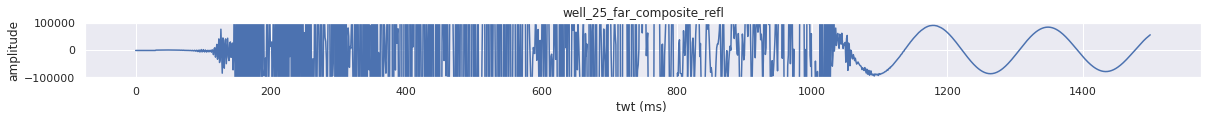

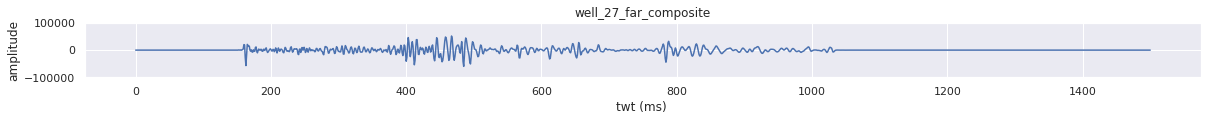

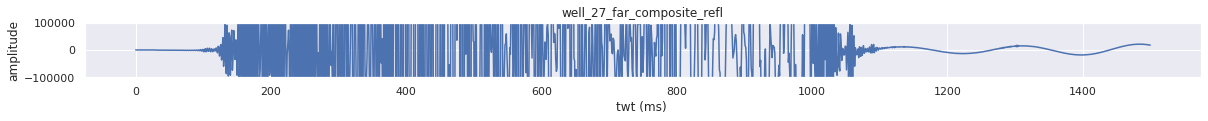

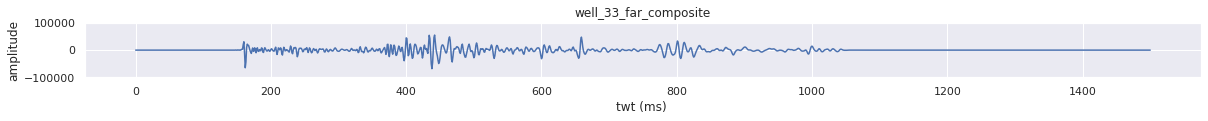

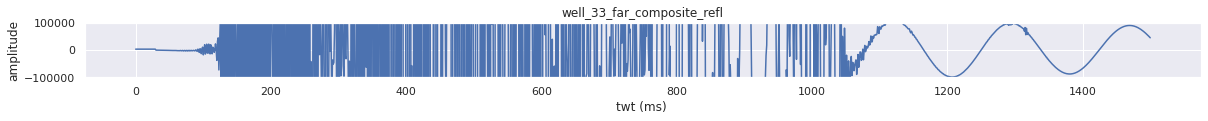

In [7]:
for composite in df:
    plt.figure(figsize=(20,1))
    plt.plot(df[composite])
    plt.title(composite)
    plt.ylim(-100000,100000)
    plt.xlabel('twt (ms) ')
    plt.ylabel('amplitude')

### Well Velocity composite

In [8]:
## Getting the well velocity composite
first_velocity = seismic_names[3]
print(first_velocity)
df_vel = pd.DataFrame(np.mean((np.mean(well_seismic['well_01'][first_velocity],axis=1)), axis=0),
                                        columns=['well_01_' + first_velocity + '_composite'])
for well in wells.keys():
        df_vel[well + '_' + first_velocity + '_composite'] = np.mean((np.mean(well_seismic[well][first_velocity],axis=1)), axis=0)

df_vel.head()

velocity


well_01_velocity_composite  well_07_velocity_composite  \
0                 1523.470219                 1523.457274   
1                 1523.470219                 1523.457274   
2                 1523.470219                 1523.457274   
3                 1523.470219                 1523.457274   
4                 1523.470219                 1523.457274   

   well_11_velocity_composite  well_13_velocity_composite  \
0                 1523.452544                 1523.474049   
1                 1523.452544                 1523.474049   
2                 1523.452544                 1523.474049   
3                 1523.452544                 1523.474049   
4                 1523.452544                 1523.474049   

   well_21_velocity_composite  well_25_velocity_composite  \
0                 1523.463996                 1523.462119   
1                 1523.463996                 1523.462119   
2                 1523.463996                 1523.462119   
3                 1523.463996                 1523.462119   
4                 1523.463996                 1523.462119   

   well_27_velocity_composite  well_33_velocity_composite  
0                 1523.447081                 1523.457274  
1                 1523.447081                 1523.457274  
2                 1523.447081                 1523.457274  
3                 1523.447081                 1523.457274  
4                 1523.447081                 1523.457274

Velocity composites QC 

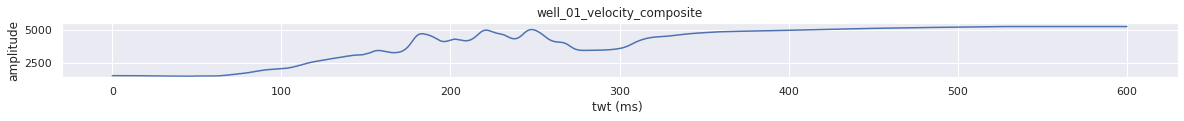

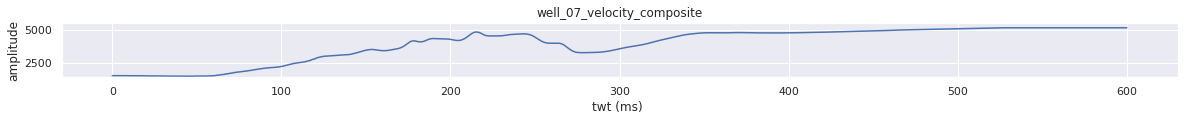

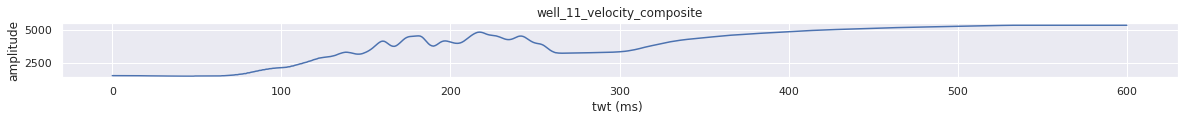

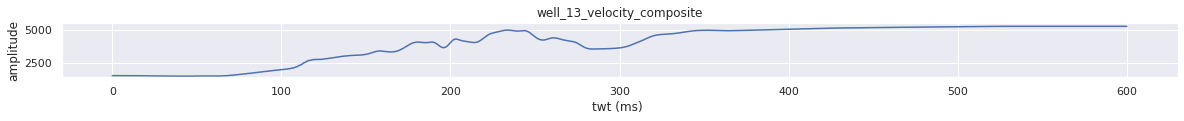

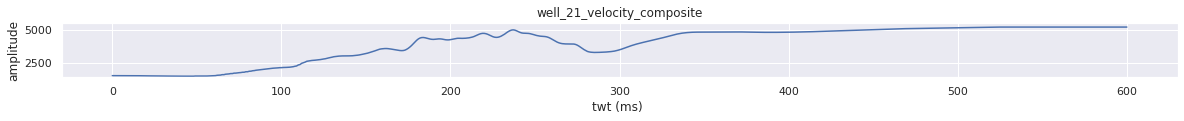

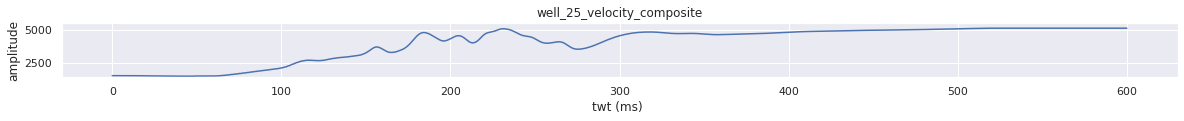

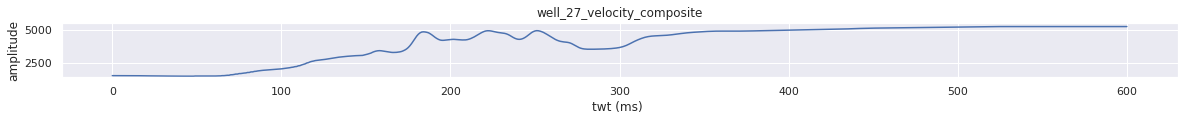

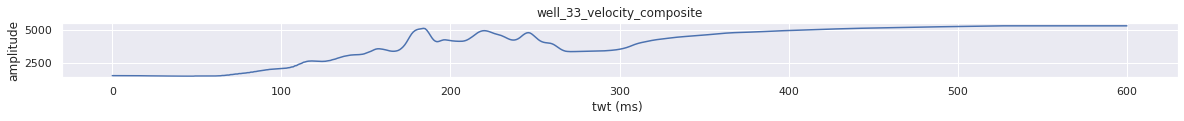

In [9]:
for composite in df_vel:
    plt.figure(figsize=(20,1))
    plt.plot(df_vel[composite])
    plt.title(composite)
    plt.ylim(1400,5500)
    plt.xlabel('twt (ms) ')
    plt.ylabel('amplitude')

Create the two-way-time indices for the training DataFrame.

We will interpolate seismic traces using `cubic` interpolation to the same sample rate as the well data, which is every 0.5 ms two-way-time.

If you recall:

*Poseidon data vertical sampling is between 0 and 6,000 milliseconds.*

*Seismic is sampled every 4 ms, and velocities are sampled every 10 ms.*



In [10]:
# index at 4ms 
seismic_twt = pd.DataFrame(np.arange(0, 6004.0, 4.0), columns=['twt'])

# index at .5 ms 
resamp_twt = pd.DataFrame(np.arange(0, 6000.5, 0.5), columns=['twt'])

# index at 10 ms 
velocity_twt = pd.DataFrame(np.arange(0, 6010.0, 10), columns=['twt'])

Merge in the acutal times

In [11]:
# Here we merge our seismic to the resamp 'twt' array
df['twt'] = seismic_twt
df_raw = df.merge(resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the seismic after the resamp
df_resamp_interp = df_raw.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
df_resamp_interp.head()

well_01_near_composite_refl  well_01_near_composite  \
0                   505.305064               -2.459141   
1                   505.305064               -2.459141   
2                   505.305064               -2.459141   
3                   505.305064               -2.459141   
4                   505.305064               -2.459141   

   well_07_near_composite  well_07_near_composite_refl  \
0               -3.686249                   249.568409   
1               -3.686249                   249.568409   
2               -3.686249                   249.568409   
3               -3.686249                   249.568409   
4               -3.686249                   249.568409   

   well_11_near_composite  well_11_near_composite_refl  \
0               -0.359645                  -859.133511   
1               -0.359645                  -859.133511   
2               -0.359645                  -859.133511   
3               -0.359645                  -859.133511   
4               -0.359645                  -859.133511   

   well_13_near_composite  well_13_near_composite_refl  \
0               -1.837291                  1290.684319   
1               -1.837291                  1290.684319   
2               -1.837291                  1290.684319   
3               -1.837291                  1290.684319   
4               -1.837291                  1290.684319   

   well_21_near_composite  well_21_near_composite_refl  ...  \
0               -3.358005                  1569.076597  ...   
1               -3.358005                  1569.076597  ...   
2               -3.358005                  1569.076597  ...   
3               -3.358005                  1569.076597  ...   
4               -3.358005                  1569.076597  ...   

   well_13_far_composite_refl  well_21_far_composite  \
0                 1290.684319               -1.54652   
1                 1290.684319               -1.54652   
2                 1290.684319               -1.54652   
3                 1290.684319               -1.54652   
4                 1290.684319               -1.54652   

   well_21_far_composite_refl  well_25_far_composite  \
0                 1569.076597              -1.273305   
1                 1569.076597              -1.273305   
2                 1569.076597              -1.273305   
3                 1569.076597              -1.273305   
4                 1569.076597              -1.273305   

   well_25_far_composite_refl  well_27_far_composite  \
0                -1273.271254              -0.613544   
1                -1273.271254              -0.613544   
2                -1273.271254              -0.613544   
3                -1273.271254              -0.613544   
4                -1273.271254              -0.613544   

   well_27_far_composite_refl  well_33_far_composite  \
0                  574.228128               -1.94823   
1                  574.228128               -1.94823   
2                  574.228128               -1.94823   
3                  574.228128               -1.94823   
4                  574.228128               -1.94823   

   well_33_far_composite_refl  twt  
0                 3570.759967  0.0  
1                 3570.759967  0.5  
2                 3570.759967  1.0  
3                 3570.759967  1.5  
4                 3570.759967  2.0  

[5 rows x 49 columns]

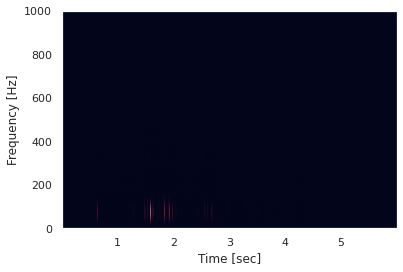

6000.0 (8193, 799) 8193 799


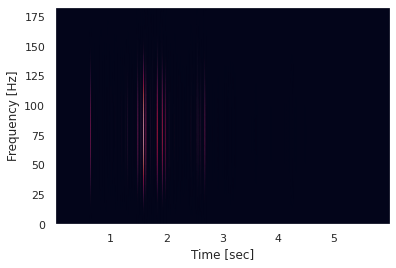

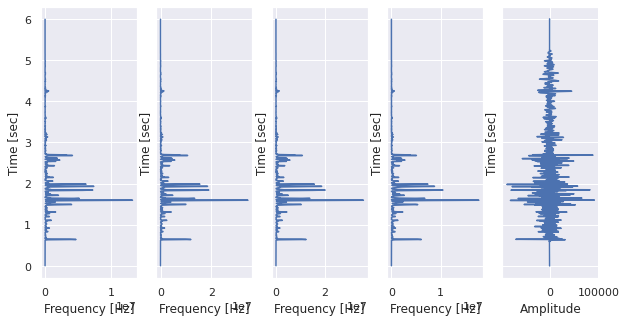

In [12]:
from scipy import signal
from scipy.fft import fftshift
fs = 20e2
N = 1e5
nfft=2**14
nperseg=20
noverlap=5
f, t, Sxx = signal.spectrogram(df_resamp_interp['well_01_near_composite'], fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

print(np.max(df_resamp_interp['twt']) - np.min(df_resamp_interp['twt']), Sxx.shape, len(f), len(t))

plt.pcolormesh(t, f[:1501], Sxx[:1501,:], shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


fig, ax = plt.subplots(1, 5, sharey='all',figsize=(10,5))
ax[0].plot(np.abs(Sxx[250:251,:]).flatten(), t)
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('Time [sec]')
ax[1].plot(np.abs(Sxx[500:501,:]).flatten(), t)
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Time [sec]')
ax[2].plot(np.abs(Sxx[750:751,:]).flatten(), t)
ax[2].set_xlabel('Frequency [Hz]')
ax[2].set_ylabel('Time [sec]')
ax[3].plot(np.abs(Sxx[1000:1001,:]).flatten(), t)
ax[3].set_xlabel('Frequency [Hz]')
ax[3].set_ylabel('Time [sec]')
ax[4].plot(df_resamp_interp['well_01_near_composite'], df_resamp_interp['twt']/1000)
ax[4].set_xlabel('Amplitude')
ax[4].set_ylabel('Time [sec]')
plt.show()

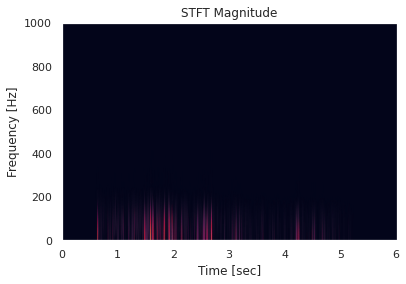

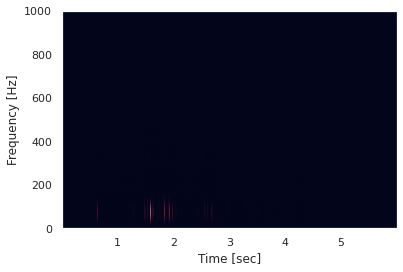

In [13]:

fZ, tZ, Zxx = signal.stft(df_resamp_interp['well_01_near_composite'], fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)
plt.pcolormesh(tZ, fZ, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Sxx = signal.spectrogram(df_resamp_interp['well_01_near_composite'], fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


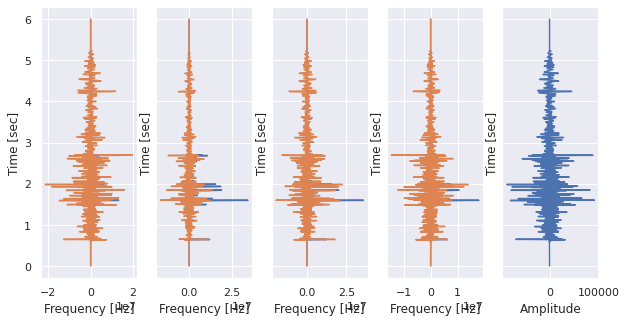

In [14]:

fig, ax = plt.subplots(1, 5, sharey='all',figsize=(10,5))
ax[0].plot(Sxx[250:251,:].flatten(), t)
ax[0].plot(Zxx[250:251,:].flatten()*500, tZ)
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('Time [sec]')
ax[1].plot(Sxx[500:501,:].flatten(), t)
ax[1].plot(Zxx[500:501,:].flatten()*500, tZ)
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Time [sec]')
ax[2].plot(Sxx[750:751,:].flatten(), t)
ax[2].plot(Zxx[750:751,:].flatten()*500, tZ)
ax[2].set_xlabel('Frequency [Hz]')
ax[2].set_ylabel('Time [sec]')
ax[3].plot(Sxx[1000:1001,:].flatten(), t)
ax[3].plot(Zxx[1000:1001,:].flatten()*500, tZ)
ax[3].set_xlabel('Frequency [Hz]')
ax[3].set_ylabel('Time [sec]')
ax[4].plot(df_resamp_interp['well_01_near_composite'], df_resamp_interp['twt']/1000)
ax[4].set_xlabel('Amplitude')
ax[4].set_ylabel('Time [sec]')
plt.show()

In [15]:
df_resamp_interp.columns

Index(['well_01_near_composite_refl', 'well_01_near_composite',
       'well_07_near_composite', 'well_07_near_composite_refl',
       'well_11_near_composite', 'well_11_near_composite_refl',
       'well_13_near_composite', 'well_13_near_composite_refl',
       'well_21_near_composite', 'well_21_near_composite_refl',
       'well_25_near_composite', 'well_25_near_composite_refl',
       'well_27_near_composite', 'well_27_near_composite_refl',
       'well_33_near_composite', 'well_33_near_composite_refl',
       'well_01_mid_composite', 'well_01_mid_composite_refl',
       'well_07_mid_composite', 'well_07_mid_composite_refl',
       'well_11_mid_composite', 'well_11_mid_composite_refl',
       'well_13_mid_composite', 'well_13_mid_composite_refl',
       'well_21_mid_composite', 'well_21_mid_composite_refl',
       'well_25_mid_composite', 'well_25_mid_composite_refl',
       'well_27_mid_composite', 'well_27_mid_composite_refl',
       'well_33_mid_composite', 'well_33_mid_composite

In [16]:
def get_specttime(data, fs, nperseg, nfft, noverlap, wname):
    
    f, t, Sxx = signal.spectrogram(data.values, fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)
    fZ, tZ, Zxx = signal.stft(data.values, fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)
    
    Sxx = np.abs(Sxx)
    Zxx = np.abs(Zxx)
    #if tadd == True:
    spectrogram_twt = pd.DataFrame(t*1000, columns=['twt'])
    stft_twt = pd.DataFrame(tZ*1000, columns=['twt'])
        
    df_spft = pd.DataFrame(Sxx[250:1001:500, :].T, columns=[wname+'_spft0', wname+'_spft1']) #, wname+'_spft2', wname+'_spft3'])
    df_stft = pd.DataFrame(Zxx[250:1001:500, :].T, columns=[wname+'_stft0', wname+'_stft1']) #, wname+'_stft2', wname+'_stft3'])
    
    df_spft = df_spft.join(spectrogram_twt, how='outer') #.merge(spectrogram_twt)
    df_stft = df_stft.join(stft_twt, how='outer') #.merge(stft_twt)
        
    df_spft_raw = df_spft.merge(resamp_twt, how='right', on=['twt'])
    df_stft_raw = df_stft.merge(resamp_twt, how='right', on=['twt'])

    # Here we interpolate the gaps in the seismic after the resamp
    df_spft_resamp_interp = df_spft_raw.interpolate(method='cubic', limit_direction='forward', axis=0)
    df_stft_resamp_interp = df_stft_raw.interpolate(method='cubic', limit_direction='forward', axis=0)
        
    return df_spft_resamp_interp, df_stft_resamp_interp

new_attributes_sp = []
new_attributes_st = []

for i in range(48):
    data = df_resamp_interp[df_resamp_interp.columns[i]]
    #if i < 17:
    df_spft_temp, df_stft_temp = get_specttime(data, fs, nperseg, nfft, noverlap, df_resamp_interp.columns[i])
    #else:
    #df_spft_temp, df_stft_temp = get_specttime(data, fs, nperseg, nfft, noverlap, True, df_resamp_interp.columns[i])
        
    new_attributes_sp.append(df_spft_temp)
    new_attributes_st.append(df_stft_temp)
    
df_sp = reduce(lambda x, y: pd.merge(x, y, on='twt'), new_attributes_sp)
df_st = reduce(lambda x, y: pd.merge(x, y, on='twt'), new_attributes_st)

print(df_st.columns)
df_st.head()

Index(['well_01_near_composite_refl_stft0',
       'well_01_near_composite_refl_stft1', 'twt',
       'well_01_near_composite_stft0', 'well_01_near_composite_stft1',
       'well_07_near_composite_stft0', 'well_07_near_composite_stft1',
       'well_07_near_composite_refl_stft0',
       'well_07_near_composite_refl_stft1', 'well_11_near_composite_stft0',
       'well_11_near_composite_stft1', 'well_11_near_composite_refl_stft0',
       'well_11_near_composite_refl_stft1', 'well_13_near_composite_stft0',
       'well_13_near_composite_stft1', 'well_13_near_composite_refl_stft0',
       'well_13_near_composite_refl_stft1', 'well_21_near_composite_stft0',
       'well_21_near_composite_stft1', 'well_21_near_composite_refl_stft0',
       'well_21_near_composite_refl_stft1', 'well_25_near_composite_stft0',
       'well_25_near_composite_stft1', 'well_25_near_composite_refl_stft0',
       'well_25_near_composite_refl_stft1', 'well_27_near_composite_stft0',
       'well_27_near_composite_stft

well_01_near_composite_refl_stft0  well_01_near_composite_refl_stft1  twt  \
0                         272.026246                         228.638949  0.0   
1                         286.728969                         232.710806  0.5   
2                         300.730531                         236.587189  1.0   
3                         314.047576                         240.272780  1.5   
4                         326.696747                         243.772257  2.0   

   well_01_near_composite_stft0  well_01_near_composite_stft1  \
0                      1.323855                      1.112705   
1                      1.394666                      1.132220   
2                      1.462148                      1.150818   
3                      1.526379                      1.168520   
4                      1.587437                      1.185348   

   well_07_near_composite_stft0  well_07_near_composite_stft1  \
0                      1.984458                      1.667943   
1                      2.090603                      1.697197   
2                      2.191759                      1.725075   
3                      2.288041                      1.751611   
4                      2.379566                      1.776835   

   well_07_near_composite_refl_stft0  well_07_near_composite_refl_stft1  \
0                         134.352815                         112.923980   
1                         141.614344                         114.934934   
2                         148.529582                         116.849358   
3                         155.106751                         118.669564   
4                         161.354068                         120.397861   

   well_11_near_composite_stft0  ...  well_25_far_composite_refl_stft0  \
0                      0.193612  ...                        685.453648   
1                      0.203968  ...                        722.507771   
2                      0.213837  ...                        757.794414   
3                      0.223231  ...                        791.355546   
4                      0.232160  ...                        823.233136   

   well_25_far_composite_refl_stft1  well_27_far_composite_stft0  \
0                        576.126031                     0.330296   
1                        586.388007                     0.347963   
2                        596.157238                     0.364799   
3                        605.445525                     0.380825   
4                        614.264669                     0.396058   

   well_27_far_composite_stft1  well_27_far_composite_refl_stft0  \
0                     0.277615                        309.130332   
1                     0.282484                        325.834215   
2                     0.287124                        341.741781   
3                     0.291540                        356.871925   
4                     0.295739                        371.243541   

   well_27_far_composite_refl_stft1  well_33_far_composite_stft0  \
0                        259.825054                     1.048811   
1                        264.451824                     1.104910   
2                        268.856513                     1.158372   
3                        273.044436                     1.209259   
4                        277.020912                     1.257631   

   well_33_far_composite_stft1  well_33_far_composite_refl_stft0  \
0                     0.881529                       1922.285167   
1                     0.896990                       2026.159371   
2                     0.911724                       2125.081408   
3                     0.925749                       2219.168786   
4                     0.939080                       2308.539009   

   well_33_far_composite_refl_stft1  
0                       1615.686964  
1                       1644.456854  
2                       1671.845880  
3                       1697.887096  
4                 

In [17]:
# Here we merge our seismic to the resamp 'twt' array
df_vel['twt'] = velocity_twt
df_raw_vel = df_vel.merge(resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the seismic after the resamp
df_resamp_vel_interp = df_raw_vel.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
df_resamp_vel_interp.head()

well_01_velocity_composite  well_07_velocity_composite  \
0                 1523.470219                 1523.457274   
1                 1523.470526                 1523.457536   
2                 1523.470786                 1523.457757   
3                 1523.471001                 1523.457940   
4                 1523.471174                 1523.458087   

   well_11_velocity_composite  well_13_velocity_composite  \
0                 1523.452544                 1523.474049   
1                 1523.452804                 1523.474335   
2                 1523.453025                 1523.474576   
3                 1523.453208                 1523.474776   
4                 1523.453355                 1523.474937   

   well_21_velocity_composite  well_25_velocity_composite  \
0                 1523.463996                 1523.462119   
1                 1523.464278                 1523.462399   
2                 1523.464516                 1523.462637   
3                 1523.464714                 1523.462833   
4                 1523.464872                 1523.462991   

   well_27_velocity_composite  well_33_velocity_composite  twt  
0                 1523.447081                 1523.457274  0.0  
1                 1523.447341                 1523.457536  0.5  
2                 1523.447561                 1523.457757  1.0  
3                 1523.447743                 1523.457940  1.5  
4                 1523.447889                 1523.458087  2.0

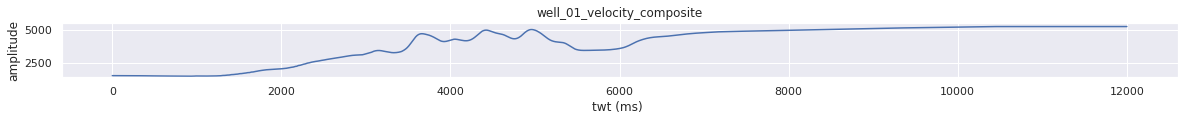

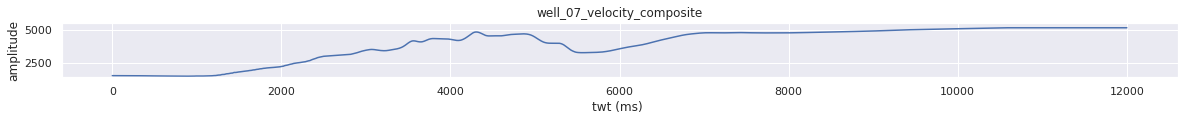

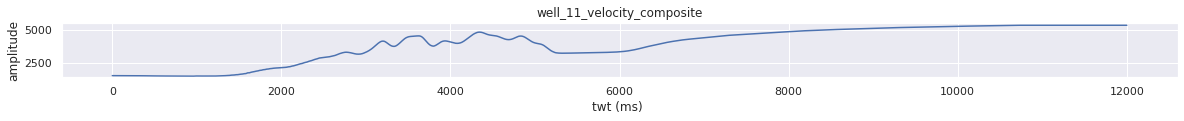

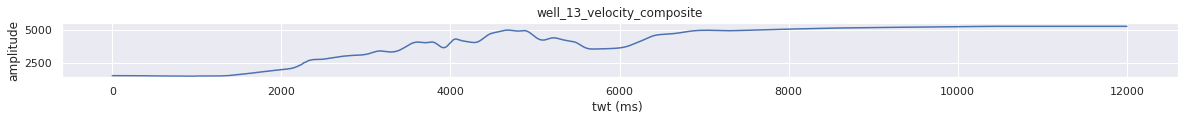

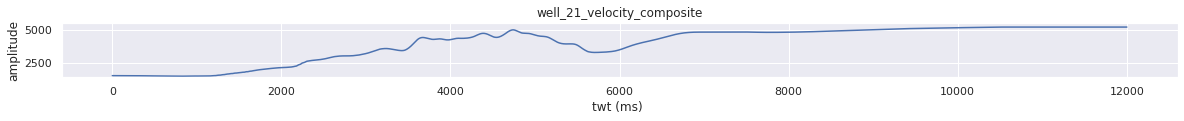

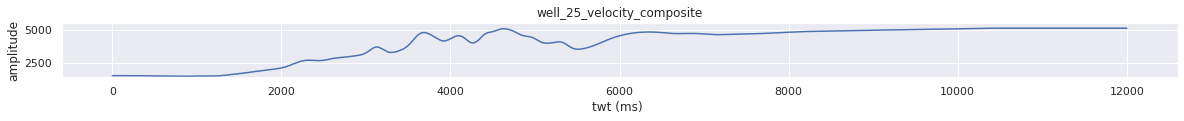

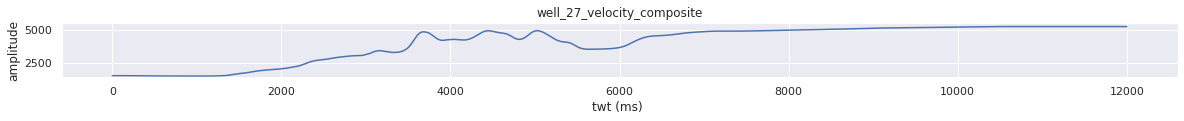

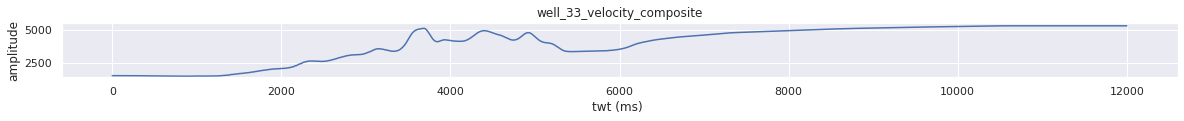

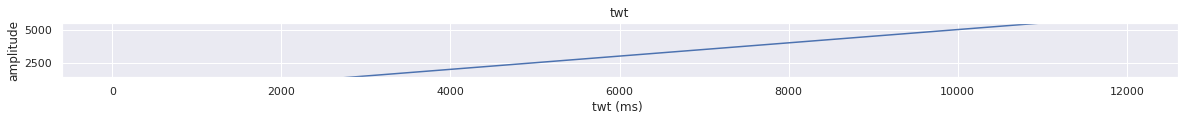

In [18]:
for composite in df_resamp_vel_interp:
    plt.figure(figsize=(20,1))
    plt.plot(df_resamp_vel_interp[composite])
    plt.title(composite)
    plt.ylim(1400,5500)
    plt.xlabel('twt (ms) ')
    plt.ylabel('amplitude')

The new data frames are "df_resamp_vel_interp" for the well velocity resampled and the "df_resamp_interp" the well seismic resampled

In [19]:
## Save the new data frames 

dfvel_main = df_resamp_vel_interp.copy()
dfseismic_main = df_resamp_interp.copy()

In [20]:
#df_resamp_vel_interp = df_resamp_vel_interp.reset_index()
#df_resamp_interp = df_resamp_interp.reset_index()

### Horizons

In [21]:
%%capture

horizon_bucket = 's3://sagemaker-gitc2021/poseidon/horizons/'
horizon_files = ['water_bottom', 'top_heywood', 'top_johnson', 'top_jameison', 'top_near_plover']

horizons = []
for horizon in horizon_files:
    horizons.append(
        read_csv(filepath_or_buffer=horizon_bucket + f'{horizon}.csv.gz',
                 index_col=[0, 1],
                 compression='gzip'))

horizons = concat(horizons, axis=1)

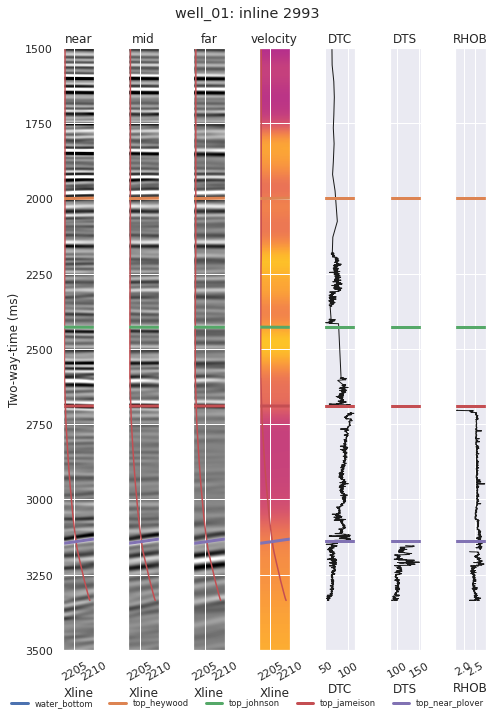

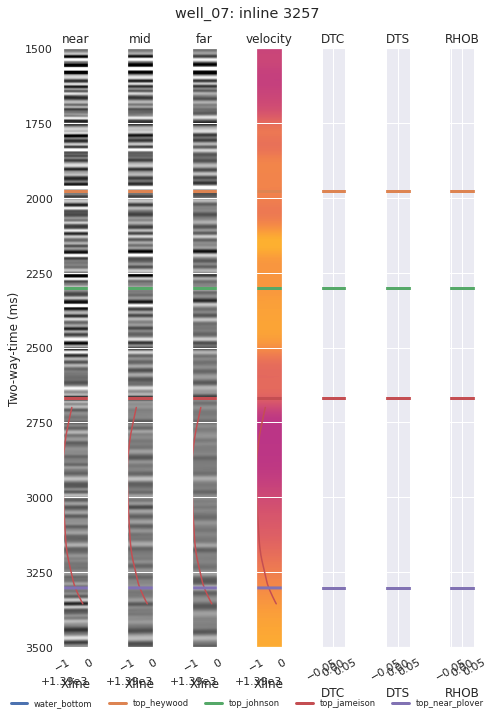

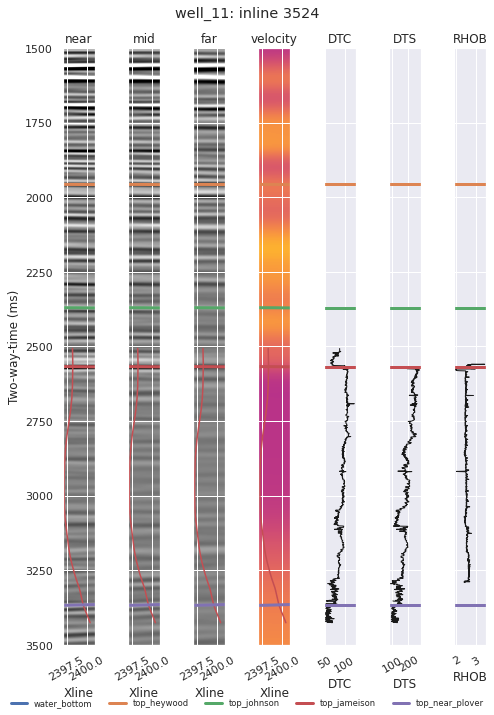

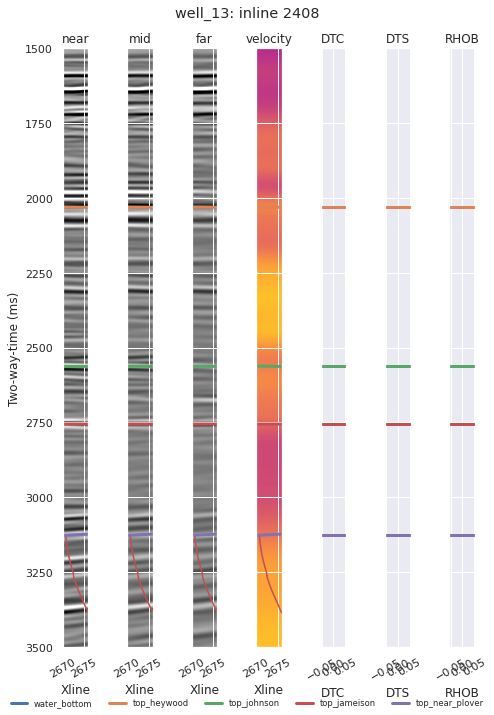

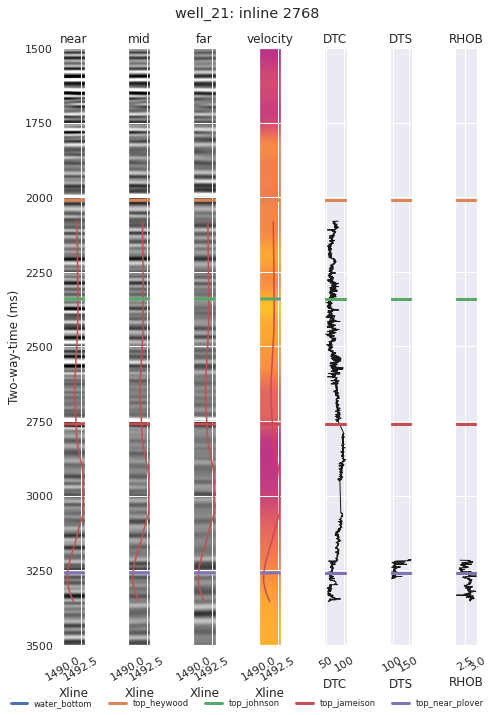

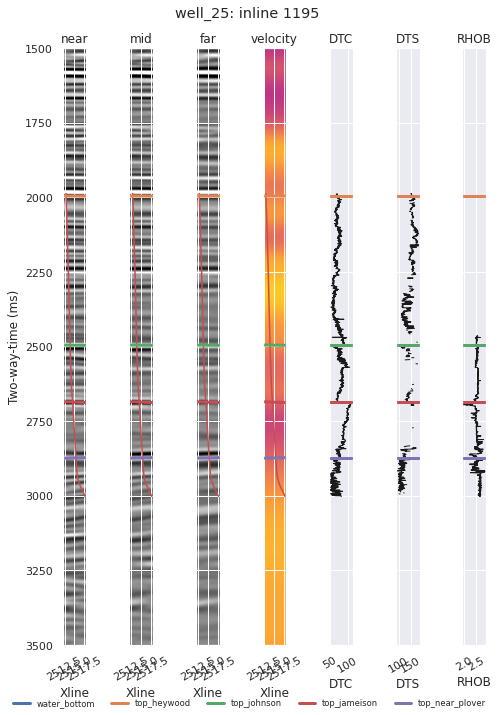

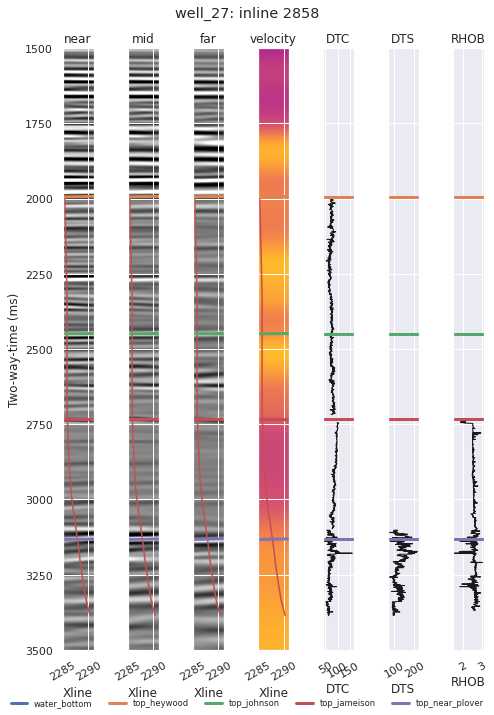

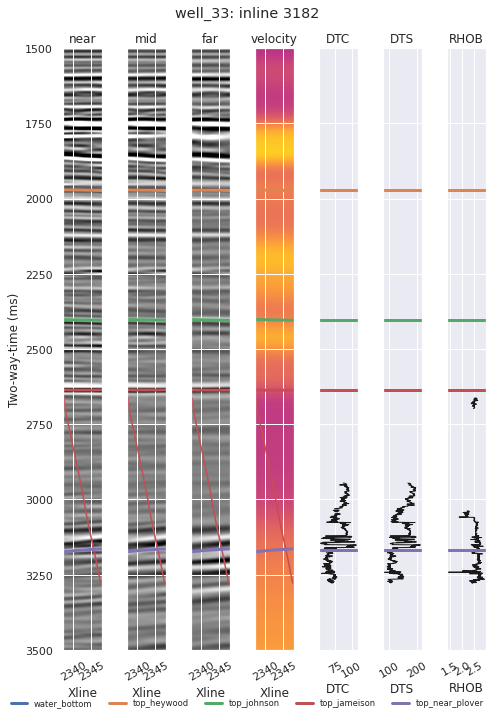

In [22]:
import matplotlib.pyplot as plt

colors = ['gray_r']*3 + ['plasma']
vmins = [-39000]*3 + [1500]
vmaxs = [39000]*3 + [5500]

for well in wells.keys():
    il_min, il_max = il_ranges[well]
    xl_min, xl_max = xl_ranges[well]
    ils = range(il_min, il_max + 1, 1)  # inline increment is 1
    xls = range(xl_min, xl_max + 1, 1)  # inline increment is 1

    # We just want to plot the "center" inline and all crosslines
    num_il = il_max - il_min + 1
    plot_il_idx = num_il // 2

    fig, axes = plt.subplots(1, 7, sharey='all', figsize=(7, 10))

    # Let's filter horizon to the il/xl range we need

    minicube_horizons = horizons.loc[IndexSlice[il_min:il_max, xl_min:xl_max], :]

    for idx, (axis, seismic_name) in enumerate(zip(axes[:6], seismic_names)):
        seismic = well_seismic[well][seismic_name]
        # mean, std = np.nanmean(seismic), np.nanstd(seismic)
        axis.imshow(seismic[plot_il_idx, :, :].T, aspect='auto',
                    extent=[xl_min, xl_max, 6000, 0], interpolation='bicubic',
                    vmin=vmins[idx], vmax=vmaxs[idx], cmap=colors[idx])

        axis.set_xlabel('Xline')
        axis.plot(wells[well]['xline'], wells[well].index.values, 'r')
        axis.set_title(seismic_name)
        axis.tick_params(axis='x', rotation=30)
        hrz_lines = axis.plot(minicube_horizons.loc[ils[plot_il_idx]], lw=3)

    axes[4].plot(wells[well]['dtc'], wells[well].index.values, 'k', lw=1)
    axes[4].set_title('DTC'), axes[4].set_xlabel('DTC')
    axes[5].plot(wells[well]['dts'], wells[well].index.values, 'k', lw=1)
    axes[5].set_title('DTS'), axes[5].set_xlabel('DTS')
    axes[6].plot(wells[well]['rhob'], wells[well].index.values, 'k', lw=1)
    axes[6].set_title('RHOB'), axes[6].set_xlabel('RHOB')

    hrz_colors = [hrz_line.get_color() for hrz_line in hrz_lines]
    hrz_labels = horizons.keys()
    for idx, value in enumerate(minicube_horizons.loc[ils[plot_il_idx], round(np.mean(xls))].values):
        axes[4].axhline(value, lw=3, color=hrz_colors[idx])
        axes[4].tick_params(axis='x', rotation=30)
        axes[5].axhline(value, lw=3, color=hrz_colors[idx])
        axes[5].tick_params(axis='x', rotation=30)
        axes[6].axhline(value, lw=3, color=hrz_colors[idx], label=hrz_labels[idx])
        axes[6].tick_params(axis='x', rotation=30)

    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(hrz_labels),
               fontsize='x-small', markerscale=0.1, frameon=False)

    axes[0].set_ylabel('Two-way-time (ms)')
    axes[0].set_ylim([3500, 1500])
    fig.suptitle(well + f': inline {ils[plot_il_idx]}')
    fig.tight_layout()

    for axis in axes:
        axis.grid('minor')

### Wells!

In [23]:
 well_df.head()

tvdss     inline      xline   gamma   rshal   rdeep  nphi  \
well_id twt                                                                     
well_01 1136.5  2798.4675  2992.8834  2202.6259  8.6726  3.7827  2.2789   NaN   
        1137.0  2798.4723  2992.8834  2202.6259  8.6323  3.7982  2.2860   NaN   
        1137.5  2798.4771  2992.8834  2202.6258  8.5921  3.8136  2.2931   NaN   
        1138.0  2798.4819  2992.8834  2202.6258  8.5518  3.8290  2.3002   NaN   
        1138.5  2798.4867  2992.8834  2202.6258  8.5115  3.8445  2.3073   NaN   

                cal  rhob      dtc  dts  p_impedance  s_impedance  
well_id twt                                                        
well_01 1136.5  NaN   NaN  58.3867  NaN          NaN          NaN  
        1137.0  NaN   NaN  58.4215  NaN          NaN          NaN  
        1137.5  NaN   NaN  58.4564  NaN          NaN          NaN  
        1138.0  NaN   NaN  58.4912  NaN          NaN          NaN  
        1138.5  NaN   NaN  58.5260  NaN          NaN          NaN

Fit the logs to inflin the NANs

In [24]:
df_well_t = pd.read_csv('well_rhob_imp-dtc_imp-dts.csv')
df_well_t.columns = ['well', 'twt', 'rhob_new', 'imp_dtc_new', 'imp_dts_new']
df_well_t.head()

well     twt  rhob_new   imp_dtc_new   imp_dts_new
0  well_01  1136.5  2.651581  45414.118393  27966.181779
1  well_01  1137.0  2.651489  45385.502500  27949.107910
2  well_01  1137.5  2.651397  45356.838596  27932.004723
3  well_01  1138.0  2.651306  45328.290883  27914.970197
4  well_01  1138.5  2.651215  45299.777119  27897.955264

In [25]:
df_well_t[df_well_t['well'] == 'well_01']

well     twt  rhob_new   imp_dtc_new   imp_dts_new
0     well_01  1136.5  2.651581  45414.118393  27966.181779
1     well_01  1137.0  2.651489  45385.502500  27949.107910
2     well_01  1137.5  2.651397  45356.838596  27932.004723
3     well_01  1138.0  2.651306  45328.290883  27914.970197
4     well_01  1138.5  2.651215  45299.777119  27897.955264
...       ...     ...       ...           ...           ...
4347  well_01  3333.5  2.625300  47723.616401  28197.166428
4348  well_01  3334.0  2.604000  47027.888043  26008.425771
4349  well_01  3334.5  2.673800  46171.884848  28048.451712
4350  well_01  3335.0  2.250500  39191.476616  26364.004845
4351  well_01  3335.5  2.488400  45671.201852  28376.040696

[4352 rows x 5 columns]

In [26]:
## Impedance - log
df_well_t['imp_dtc_new_log'] = np.log(df_well_t['imp_dtc_new'])
df_well_t['imp_dts_new_log'] = np.log(df_well_t['imp_dts_new'])
df_well_t['rhob_new_log'] = np.log(df_well_t['rhob_new'])
df_well_t.head()

well     twt  rhob_new   imp_dtc_new   imp_dts_new  imp_dtc_new_log  \
0  well_01  1136.5  2.651581  45414.118393  27966.181779        10.723578   
1  well_01  1137.0  2.651489  45385.502500  27949.107910        10.722948   
2  well_01  1137.5  2.651397  45356.838596  27932.004723        10.722316   
3  well_01  1138.0  2.651306  45328.290883  27914.970197        10.721687   
4  well_01  1138.5  2.651215  45299.777119  27897.955264        10.721057   

   imp_dts_new_log  rhob_new_log  
0        10.238751      0.975156  
1        10.238141      0.975121  
2        10.237528      0.975087  
3        10.236918      0.975052  
4        10.236309      0.975018

In [27]:
df_well_t.columns

Index(['well', 'twt', 'rhob_new', 'imp_dtc_new', 'imp_dts_new',
       'imp_dtc_new_log', 'imp_dts_new_log', 'rhob_new_log'],
      dtype='object')

Now we need to merge these two on the twt column - this gives us the association in twt of the well data and the composite trace. This is were good well-ties plays the most important role. 

In [28]:
df_sp.head()

well_01_near_composite_refl_spft0  well_01_near_composite_refl_spft1  twt  \
0                                NaN                                NaN  0.0   
1                                NaN                                NaN  0.5   
2                                NaN                                NaN  1.0   
3                                NaN                                NaN  1.5   
4                                NaN                                NaN  2.0   

   well_01_near_composite_spft0  well_01_near_composite_spft1  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   well_07_near_composite_spft0  well_07_near_composite_spft1  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   well_07_near_composite_refl_spft0  well_07_near_composite_refl_spft1  \
0                                NaN                                NaN   
1                                NaN                                NaN   
2                                NaN                                NaN   
3                                NaN                                NaN   
4                                NaN                                NaN   

   well_11_near_composite_spft0  ...  well_25_far_composite_refl_spft0  \
0                           NaN  ...                               NaN   
1                           NaN  ...                               NaN   
2                           NaN  ...                               NaN   
3                           NaN  ...                               NaN   
4                           NaN  ...                               NaN   

   well_25_far_composite_refl_spft1  well_27_far_composite_spft0  \
0                               NaN                          NaN   
1                               NaN                          NaN   
2                               NaN                          NaN   
3                               NaN                          NaN   
4                               NaN                          NaN   

   well_27_far_composite_spft1  well_27_far_composite_refl_spft0  \
0                          NaN                               NaN   
1                          NaN                               NaN   
2                          NaN                               NaN   
3                          NaN                               NaN   
4                          NaN                               NaN   

   well_27_far_composite_refl_spft1  well_33_far_composite_spft0  \
0                               NaN                          NaN   
1                               NaN                          NaN   
2                               NaN                          NaN   
3                               NaN                          NaN   
4                               NaN                          NaN   

   well_33_far_composite_spft1  well_33_far_composite_refl_spft0  \
0                          NaN                               NaN   
1                          NaN                               NaN   
2                          NaN                               NaN   
3                          NaN                               NaN   
4                          NaN                               NaN   

   well_33_far_composite_refl_spft1  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                 

In [29]:
tt_independent_wells = []
df_resamp_interp_new = df_resamp_interp.merge(df_resamp_vel_interp, on='twt')
df_resamp_interp_new = df_resamp_interp_new.merge(df_sp, on='twt')
df_resamp_interp_new = df_resamp_interp_new.merge(df_st, on='twt')

print(df_resamp_interp_new.columns)


Index(['well_01_near_composite_refl', 'well_01_near_composite',
       'well_07_near_composite', 'well_07_near_composite_refl',
       'well_11_near_composite', 'well_11_near_composite_refl',
       'well_13_near_composite', 'well_13_near_composite_refl',
       'well_21_near_composite', 'well_21_near_composite_refl',
       ...
       'well_25_far_composite_refl_stft0', 'well_25_far_composite_refl_stft1',
       'well_27_far_composite_stft0', 'well_27_far_composite_stft1',
       'well_27_far_composite_refl_stft0', 'well_27_far_composite_refl_stft1',
       'well_33_far_composite_stft0', 'well_33_far_composite_stft1',
       'well_33_far_composite_refl_stft0', 'well_33_far_composite_refl_stft1'],
      dtype='object', length=249)


In [30]:
df_more_features = pd.read_csv('seismic_new_features_extended.csv')
df_more_features_blk = pd.read_csv('seismic_new_features_extended_4Prediction.csv')
df_more_features_new = pd.concat([df_more_features, df_more_features_blk], axis=1)
#df_more_features_new = df_more_features
col_drop = ['Unnamed: 0', 'well_01_near_composite', 'well_01_mid_composite',
       'well_01_far_composite',  'well_07_near_composite', 'well_07_mid_composite',
       'well_07_far_composite','well_11_near_composite','well_11_mid_composite', 'well_11_far_composite','well_13_near_composite','well_13_mid_composite', 'well_13_far_composite',
       'well_21_near_composite', 'well_21_mid_composite','well_21_far_composite', 'well_25_near_composite', 'well_25_mid_composite', 'well_25_far_composite',
        'well_27_near_composite', 'well_27_mid_composite', 'well_27_far_composite','well_33_near_composite','well_33_mid_composite','well_33_far_composite']
df_more_features_new = df_more_features_new.drop(col_drop, axis=1)
df_more_features_new.head()

twt  well_01_mid_near_diff  well_01_far_near_diff  well_01_far_mid_diff  \
0  0.0               0.282037               1.264097               0.98206   
1  0.5               0.282037               1.264097               0.98206   
2  1.0               0.282037               1.264097               0.98206   
3  1.5               0.282037               1.264097               0.98206   
4  2.0               0.282037               1.264097               0.98206   

   well_01_average_diff  well_01_full_composite  well_11_mid_near_diff  \
0              0.842731               -1.943763              -2.696875   
1              0.842731               -1.943763              -2.696875   
2              0.842731               -1.943763              -2.696875   
3              0.842731               -1.943763              -2.696875   
4              0.842731               -1.943763              -2.696875   

   well_11_far_near_diff  well_11_far_mid_diff  well_11_average_diff  ...  \
0              -1.428449              1.268426               -0.9523  ...   
1              -1.428449              1.268426               -0.9523  ...   
2              -1.428449              1.268426               -0.9523  ...   
3              -1.428449              1.268426               -0.9523  ...   
4              -1.428449              1.268426               -0.9523  ...   

   well_13_far_mid_ratio  well_13_average_ratio  \
0                 1.0923               0.877924   
1                 1.0923               0.877924   
2                 1.0923               0.877924   
3                 1.0923               0.877924   
4                 1.0923               0.877924   

   well_07_near_ci_-90PhaseShift  well_13_near_ci_-90PhaseShift  \
0                     760.421935                    9717.928126   
1                   -1045.571534                    2814.988627   
2                    -394.465876                    3745.326283   
3                    -879.085667                    1757.839268   
4                    -481.645651                    2399.508045   

   well_07_mid_ci_-90PhaseShift  well_13_mid_ci_-90PhaseShift  \
0                    760.421935                   9717.928126   
1                  -1045.571534                   2814.988627   
2                   -394.465876                   3745.326283   
3                   -879.085667                   1757.839268   
4                   -481.645651                   2399.508045   

   well_07_far_ci_-90PhaseShift  well_13_far_ci_-90PhaseShift  well_07_bg_imp  \
0                    760.421935                   9717.928126    12995.370864   
1                  -1045.571534                   2814.988627    12995.373095   
2                   -394.465876                   3745.326283    12995.374983   
3                   -879.085667                   1757.839268    12995.376546   
4                   -481.645651                   2399.508045    12995.377801   

   well_13_bg_imp  
0    12995.513958  
1    12995.516394  
2    12995.518455  
3    12995.520161  
4    12995.521531  

[5 rows x 106 columns]

In [31]:
df_more_features_new = df_more_features_new.loc[:,~df_more_features_new.columns.duplicated()]
print(df_more_features_new.columns)

Index(['twt', 'well_01_mid_near_diff', 'well_01_far_near_diff',
       'well_01_far_mid_diff', 'well_01_average_diff',
       'well_01_full_composite', 'well_11_mid_near_diff',
       'well_11_far_near_diff', 'well_11_far_mid_diff', 'well_11_average_diff',
       ...
       'well_13_far_mid_ratio', 'well_13_average_ratio',
       'well_07_near_ci_-90PhaseShift', 'well_13_near_ci_-90PhaseShift',
       'well_07_mid_ci_-90PhaseShift', 'well_13_mid_ci_-90PhaseShift',
       'well_07_far_ci_-90PhaseShift', 'well_13_far_ci_-90PhaseShift',
       'well_07_bg_imp', 'well_13_bg_imp'],
      dtype='object', length=105)


In [32]:
well_df.index.levels[0]

Index(['well_01', 'well_07', 'well_11', 'well_13', 'well_21', 'well_25',
       'well_27', 'well_33'],
      dtype='object', name='well_id')

In [33]:
tt_independent_wells = []
#df_resamp_interp_new = df_resamp_interp.merge(df_resamp_vel_interp, on='twt')
#df_resamp_interp_new = df_resamp_interp_new.merge(df_sp, on='twt')
#df_resamp_interp_new = df_resamp_interp_new.merge(df_st, on='twt')

for well in well_df.index.levels[0]:
    seis_temp = []
    for seismic_name in seismic_names_just:
        if seismic_name == 'velocity':
            df_seis_temp = df_resamp_interp_new[[well + '_' + seismic_name + '_composite','twt']]
            df_more_features_temp = df_more_features_new[[well + '_' + seismic_name + '_ci_-90PhaseShift','twt']]
            df_seis_temp = df_seis_temp.merge(df_more_features_temp, how='right', on=['twt'])
            well_reset = df_well_t[df_well_t['well']==well][['twt', 'rhob_new', 'imp_dtc_new', 'imp_dts_new',
       'imp_dtc_new_log', 'imp_dts_new_log', 'rhob_new_log']]
            
            well_reset.reset_index(level=0, inplace=True)
            well_temp_tt = well_reset.merge(df_seis_temp, how='right', on=['twt'])
            well_temp_tt['well_name'] = [well] * len(well_temp_tt)
            well_temp_tt.set_index(['well_name'], inplace=True)
            well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite': seismic_name + "composite_trace"}, inplace=True)
            well_temp_tt.rename(columns={well + '_' + seismic_name + '_ci_-90PhaseShift': seismic_name + "_ci_-90PhaseShift"}, inplace=True)
        else:
            df_seis_temp = df_resamp_interp_new[[well + '_' + seismic_name + '_composite',well + '_' + seismic_name + '_composite_refl','twt']] #,
            df_more_features_temp = df_more_features_new[[well + '_' + seismic_name + '_ci_-90PhaseShift','twt']]
            df_seis_temp = df_seis_temp.merge(df_more_features_temp, how='right', on=['twt'])
                                        #well + '_' + seismic_name + '_composite_stft0',
                                        #well + '_' + seismic_name + '_composite_stft1',well + '_' + seismic_name + '_composite_spft0',
                                        #well + '_' + seismic_name + '_composite_spft1', 
                                        #well + '_' + seismic_name + '_composite_refl_stft0',
                                        #well + '_' + seismic_name + '_composite_refl_stft1',well + '_' + seismic_name + '_composite_refl_spft0',
                                        #well + '_' + seismic_name + '_composite_refl_spft1']]
            #well + '_' + seismic_name + '_composite_stft2', well + '_' + seismic_name + '_composite_stft3',
            #well + '_' + seismic_name + '_composite_spft2',well + '_' + seismic_name + '_composite_spft3',
            #well + '_' + seismic_name + '_composite_refl_stft2',well + '_' + seismic_name + '_composite_refl_stft3',
            #, well + '_' + seismic_name + '_composite_refl_spft2',well + '_' + seismic_name + '_composite_refl_spft3'
            well_reset = df_well_t[df_well_t['well']==well][['twt', 'rhob_new', 'imp_dtc_new', 'imp_dts_new',
       'imp_dtc_new_log', 'imp_dts_new_log', 'rhob_new_log']]
            well_reset.reset_index(level=0, inplace=True)
            well_temp_tt = well_reset.merge(df_seis_temp, how='right', on=['twt'])
            well_temp_tt['well_name'] = [well] * len(well_temp_tt)
            well_temp_tt.set_index(['well_name'], inplace=True)
            well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite': seismic_name + "_composite_trace"}, inplace=True)
            well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_refl': seismic_name + "_composite_trace_refl"}, inplace=True)
            well_temp_tt.rename(columns={well + '_' + seismic_name + '_ci_-90PhaseShift': seismic_name + "_ci_-90PhaseShift"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_stft0': "composite_trace_stft0"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_stft1': "composite_trace_stft1"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_stft2': "composite_trace_stft2"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_stft3': "composite_trace_stft3"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_spft0': "composite_trace_spft0"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_spft1': "composite_trace_spft1"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_spft2': "composite_trace_spft2"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_spft3': "composite_trace_spft3"}, inplace=True)
        
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_refl_stft0': "composite_trace_refl_stft0"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_refl_stft1': "composite_trace_refl_stft1"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_refl_stft2': "composite_trace_refl_stft2"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_refl_stft3': "composite_trace_refl_stft3"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_refl_spft0': "composite_trace_refl_spft0"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_refl_spft1': "composite_trace_refl_spft1"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_refl_spft2': "composite_trace_refl_spft2"}, inplace=True)
            #well_temp_tt.rename(columns={well + '_' + seismic_name + '_composite_refl_spft3': "composite_trace_refl_spft3"}, inplace=True)
        seis_temp.append(well_temp_tt)
    seis = pd.concat(seis_temp, axis=1)
    
    df_morefeature_temp = df_more_features_new[[well + '_mid_near_diff',well + '_far_mid_diff',well + '_far_near_diff',
                                         well + '_full_composite',well + '_average_ratio',well + '_bg_imp',
                                         well + '_mid_near_ratio',well + '_far_mid_ratio',well + '_far_near_ratio',
                                         'twt']]
    
    df_morefeature_temp.rename(columns={well + '_mid_near_diff': "mid_near_diff"}, inplace=True)
    df_morefeature_temp.rename(columns={well + '_far_mid_diff': "far_mid_diff"}, inplace=True)
    df_morefeature_temp.rename(columns={well + '_far_near_diff': "far_near_diff"}, inplace=True)
    df_morefeature_temp.rename(columns={well + '_full_composite': "full_composite"}, inplace=True)
    df_morefeature_temp.rename(columns={well + '_average_ratio': "average_ratio"}, inplace=True)
    df_morefeature_temp.rename(columns={well + '_mid_near_ratio': "mid_near_ratio"}, inplace=True)
    df_morefeature_temp.rename(columns={well + '_far_mid_ratio': "far_mid_ratio"}, inplace=True)
    df_morefeature_temp.rename(columns={well + '_far_near_ratio': "far_near_ratio"}, inplace=True)
    df_morefeature_temp.rename(columns={well + '_bg_imp': "bg_imp"}, inplace=True)
    
    seis = seis.loc[:,~seis.columns.duplicated()]
    seis = seis.merge(df_morefeature_temp, how='right', on=['twt'])
    
    df_resamp_vel_interp_temp = df_resamp_vel_interp[[well + '_velocity_composite', 'twt']]
    df_resamp_vel_interp_temp.rename(columns={well + '_velocity_composite': "velocity_composite"}, inplace=True)
    seis = seis.merge(df_resamp_vel_interp_temp, how='right', on=['twt'])
    tt_independent_wells.append(seis)

#tt_independent_wells
seis.head()

#seis.describe()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


index  twt  rhob_new  imp_dtc_new  imp_dts_new  imp_dtc_new_log  \
0    NaN  0.0       NaN          NaN          NaN              NaN   
1    NaN  0.5       NaN          NaN          NaN              NaN   
2    NaN  1.0       NaN          NaN          NaN              NaN   
3    NaN  1.5       NaN          NaN          NaN              NaN   
4    NaN  2.0       NaN          NaN          NaN              NaN   

   imp_dts_new_log  rhob_new_log  near_composite_trace  \
0              NaN           NaN             -1.578084   
1              NaN           NaN             -1.578084   
2              NaN           NaN             -1.578084   
3              NaN           NaN             -1.578084   
4              NaN           NaN             -1.578084   

   near_composite_trace_refl  ...  mid_near_diff  far_mid_diff  far_near_diff  \
0                3570.759967  ...       0.433529     -0.803674      -0.370146   
1                3570.759967  ...       0.433529     -0.803674      -0.370146   
2                3570.759967  ...       0.433529     -0.803674      -0.370146   
3                3570.759967  ...       0.433529     -0.803674      -0.370146   
4                3570.759967  ...       0.433529     -0.803674      -0.370146   

   full_composite  average_ratio        bg_imp  mid_near_ratio  far_mid_ratio  \
0       -1.556956       1.220669  12995.370864        0.725282       1.702172   
1       -1.556956       1.220669  12995.373095        0.725282       1.702172   
2       -1.556956       1.220669  12995.374983        0.725282       1.702172   
3       -1.556956       1.220669  12995.376546        0.725282       1.702172   
4       -1.556956       1.220669  12995.377801        0.725282       1.702172   

   far_near_ratio  velocity_composite  
0        1.234554         1523.457274  
1        1.234554         1523.457536  
2        1.234554         1523.457757  
3        1.234554         1523.457940  
4        1.234554         1523.458087  

[5 rows x 27 columns]

Let's take a look at what our data looks like right now. You will notice that we don't have much data for the shallow or deep sections. Most of our data is between 2500ms and 3500ms. Your final, evaluation will likely focus on this interval. 

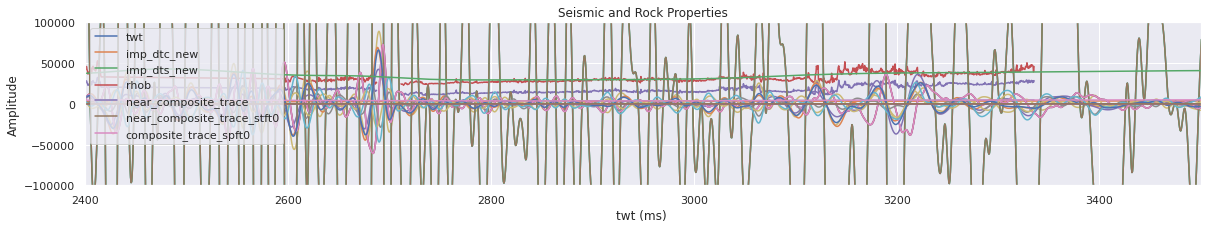

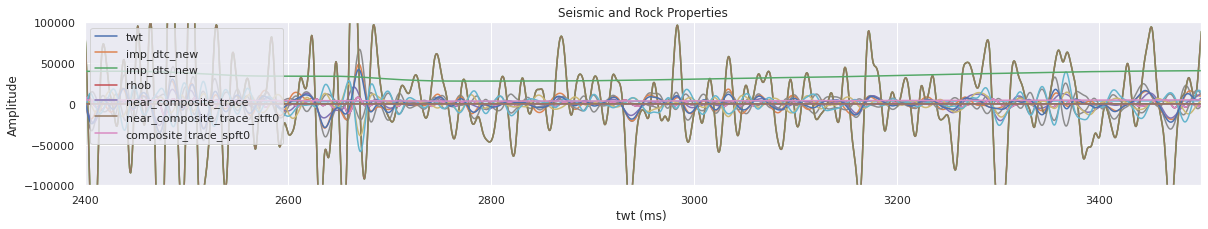

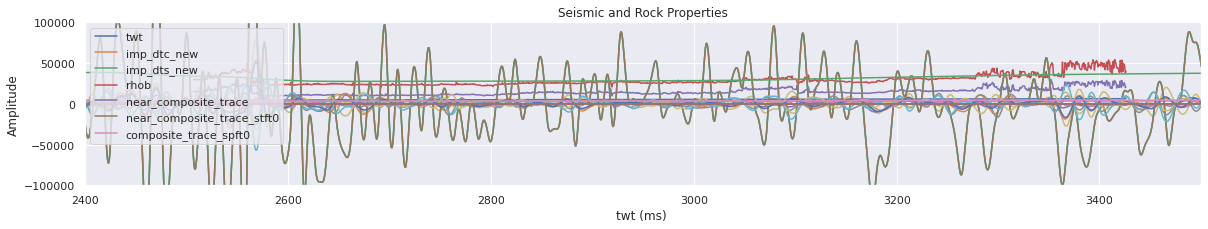

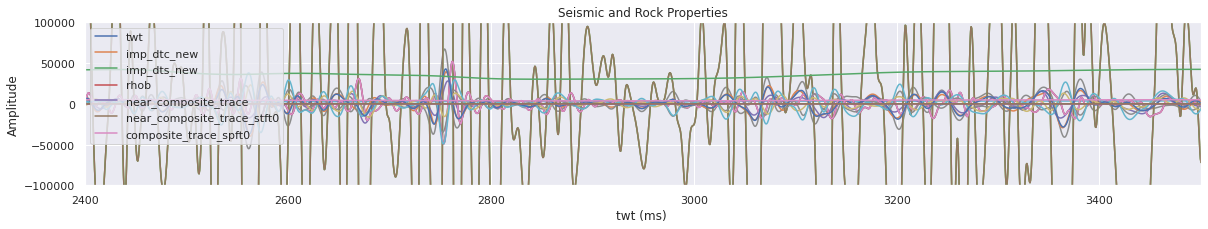

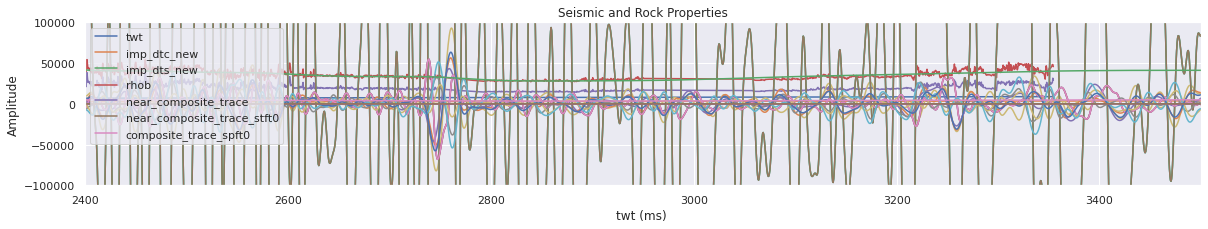

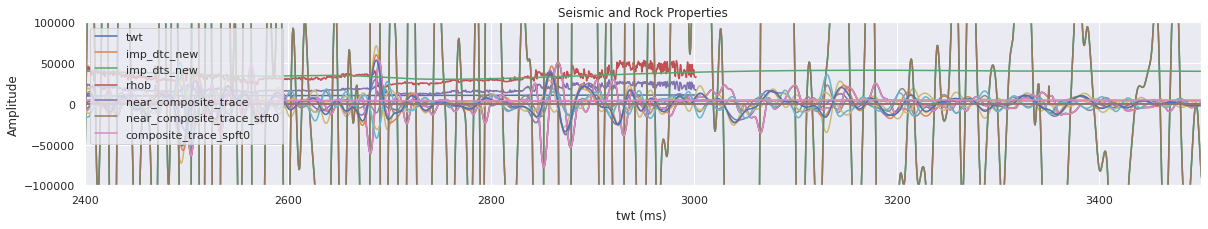

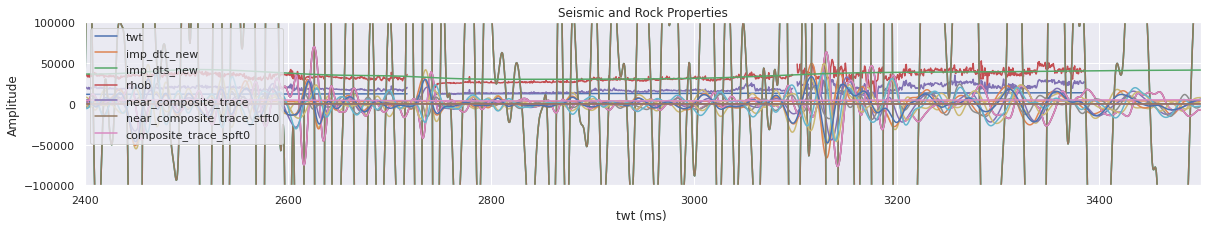

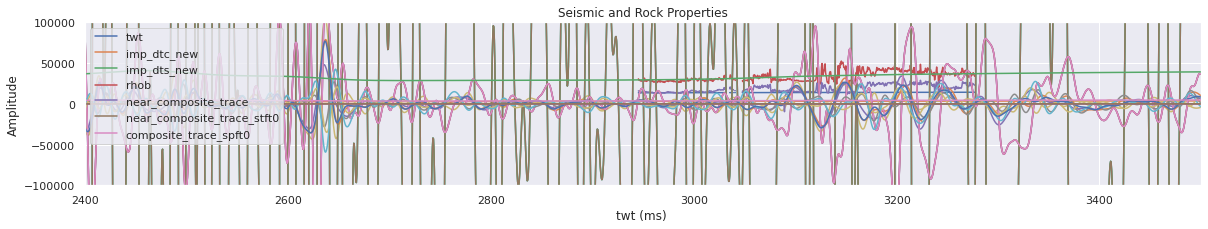

In [34]:
for tt_wells in tt_independent_wells:
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(0,6000.5,.5), tt_wells[:])
    plt.title('Seismic and Rock Properties')
    plt.ylim(-100000,100000)
    plt.xlim(2400,3500)
    plt.xlabel('twt (ms) ')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper left', labels =['twt','imp_dtc_new','imp_dts_new','rhob','near_composite_trace','near_composite_trace_stft0','composite_trace_spft0'])

In [35]:
b, a = signal.butter(4, 0.5)
tt_independent_wells_more = []
fs = 20e2
N = 1e5
nfft=2**14
nperseg=20
noverlap=5
#col1 = ['composite_trace_spft0', 'composite_trace_spft1','composite_trace_spft2', 'composite_trace_spft3']
#col2 = ['composite_trace_sfft0', 'composite_trace_sfft1','composite_trace_sfft2', 'composite_trace_sfft3']
for tt_well in tt_independent_wells:
    
    for seismic_name in seismic_names_just:
        tt_well[seismic_name + '_composite_trace'] = tt_well[seismic_name + '_composite_trace'].fillna(0)
        tt_well[seismic_name + '_GradTrail5'] = tt_well[seismic_name + '_composite_trace'].diff(periods=-5)
        tt_well[seismic_name + '_GradLead5'] = tt_well[seismic_name + '_composite_trace'].diff(periods=5)
        tt_well[seismic_name + '_GradTrail10'] = tt_well[seismic_name + '_composite_trace'].diff(periods=-10)
        tt_well[seismic_name + '_GradLead10'] = tt_well[seismic_name + '_composite_trace'].diff(periods=10)
        tt_well[seismic_name + '_HTEnv'] = np.abs(hilbert(tt_well[seismic_name + '_composite_trace']))
        tt_well[seismic_name + '_HTEnvCosPhs'] = np.cos(np.angle(hilbert(tt_well[seismic_name + '_composite_trace']))) * tt_well[seismic_name + '_HTEnv']
    #tt_well = tt_well[tt_well['twt']>2000]
    tt_well = tt_well.loc[:,~tt_well.columns.duplicated()]
    tmp = tt_well['imp_dtc_new'].fillna(value=tt_well['imp_dtc_new'].mean())
    tt_well['imp_dtc_new_filt'] = signal.filtfilt(b, a, tmp)
    tmp = tt_well['imp_dts_new'].fillna(value=tt_well['imp_dts_new'].mean())
    tt_well['imp_dts_new_filt'] = signal.filtfilt(b, a, tmp)
    tmp = tt_well['rhob_new'].fillna(value=tt_well['rhob_new'].mean())
    tt_well['rhob_new_filt'] = signal.filtfilt(b, a, tmp)
    
    tt_well['tslowness'] = tt_well['twt'].fillna(0)/tt_well['velocity_composite'].fillna(0)    
    tt_well['vel_detrend'] = signal.detrend(tt_well['velocity_composite'])   
    tt_well['vel_tdetrend'] = tt_well['velocity_composite'] - tt_well['twt']
    
    tt_well['velocity_composite_GradTrail10'] = tt_well['velocity_composite'].diff(periods=-10)
    tt_well['velocity_composite_GradLead10'] = tt_well['velocity_composite'].diff(periods=10)
    tt_well['velocity_composite_GradAcc10'] = tt_well['velocity_composite_GradLead10'] + tt_well['velocity_composite_GradTrail10']
    
    tt_well = tt_well[tt_well['twt']>2500]
    tt_independent_wells_more.append(tt_well)
    
print(tt_well.columns)
tt_well.head()
#tt_well.describe()
print(max(tt_well['twt']))

Index(['index', 'twt', 'rhob_new', 'imp_dtc_new', 'imp_dts_new',
       'imp_dtc_new_log', 'imp_dts_new_log', 'rhob_new_log',
       'near_composite_trace', 'near_composite_trace_refl',
       'near_ci_-90PhaseShift', 'mid_composite_trace',
       'mid_composite_trace_refl', 'mid_ci_-90PhaseShift',
       'far_composite_trace', 'far_composite_trace_refl',
       'far_ci_-90PhaseShift', 'mid_near_diff', 'far_mid_diff',
       'far_near_diff', 'full_composite', 'average_ratio', 'bg_imp',
       'mid_near_ratio', 'far_mid_ratio', 'far_near_ratio',
       'velocity_composite', 'near_GradTrail5', 'near_GradLead5',
       'near_GradTrail10', 'near_GradLead10', 'near_HTEnv', 'near_HTEnvCosPhs',
       'mid_GradTrail5', 'mid_GradLead5', 'mid_GradTrail10', 'mid_GradLead10',
       'mid_HTEnv', 'mid_HTEnvCosPhs', 'far_GradTrail5', 'far_GradLead5',
       'far_GradTrail10', 'far_GradLead10', 'far_HTEnv', 'far_HTEnvCosPhs',
       'imp_dtc_new_filt', 'imp_dts_new_filt', 'rhob_new_filt', 'tslowness

In [36]:
tt_independent_wells_more[0].columns

Index(['index', 'twt', 'rhob_new', 'imp_dtc_new', 'imp_dts_new',
       'imp_dtc_new_log', 'imp_dts_new_log', 'rhob_new_log',
       'near_composite_trace', 'near_composite_trace_refl',
       'near_ci_-90PhaseShift', 'mid_composite_trace',
       'mid_composite_trace_refl', 'mid_ci_-90PhaseShift',
       'far_composite_trace', 'far_composite_trace_refl',
       'far_ci_-90PhaseShift', 'mid_near_diff', 'far_mid_diff',
       'far_near_diff', 'full_composite', 'average_ratio', 'bg_imp',
       'mid_near_ratio', 'far_mid_ratio', 'far_near_ratio',
       'velocity_composite', 'near_GradTrail5', 'near_GradLead5',
       'near_GradTrail10', 'near_GradLead10', 'near_HTEnv', 'near_HTEnvCosPhs',
       'mid_GradTrail5', 'mid_GradLead5', 'mid_GradTrail10', 'mid_GradLead10',
       'mid_HTEnv', 'mid_HTEnvCosPhs', 'far_GradTrail5', 'far_GradLead5',
       'far_GradTrail10', 'far_GradLead10', 'far_HTEnv', 'far_HTEnvCosPhs',
       'imp_dtc_new_filt', 'imp_dts_new_filt', 'rhob_new_filt', 'tslowness

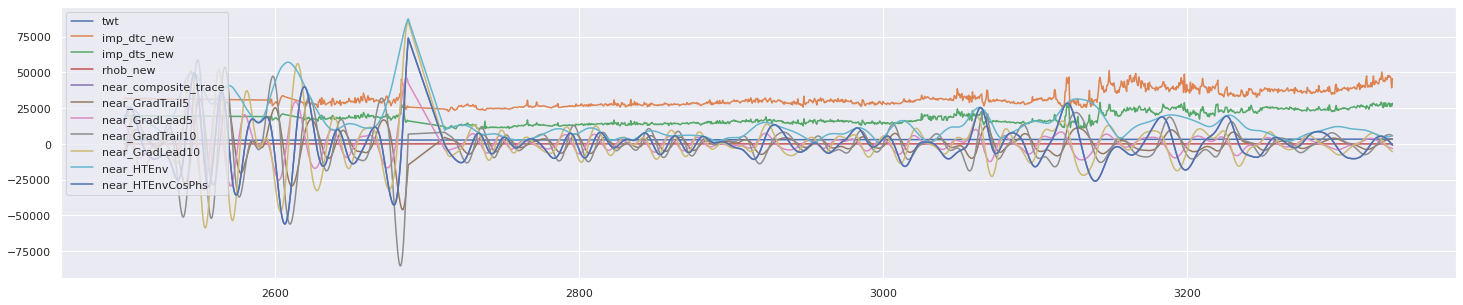

In [37]:
check = tt_independent_wells_more[0].reset_index()
check = check.dropna()
plt.figure(figsize=(25,5))
plt.plot(check['twt'], check[['twt', 
                              'imp_dtc_new', 'imp_dts_new', 'rhob_new',
                              'near_composite_trace',
                              'near_GradTrail5', 'near_GradLead5', 'near_GradTrail10', 'near_GradLead10',
                              'near_HTEnv', 'near_HTEnvCosPhs']])#

plt.legend(loc='upper left', labels =['twt', 
                                      'imp_dtc_new', 'imp_dts_new', 'rhob_new',
                                      'near_composite_trace',
                                      'near_GradTrail5', 'near_GradLead5', 'near_GradTrail10', 'near_GradLead10',
                                      'near_HTEnv', 'near_HTEnvCosPhs']);

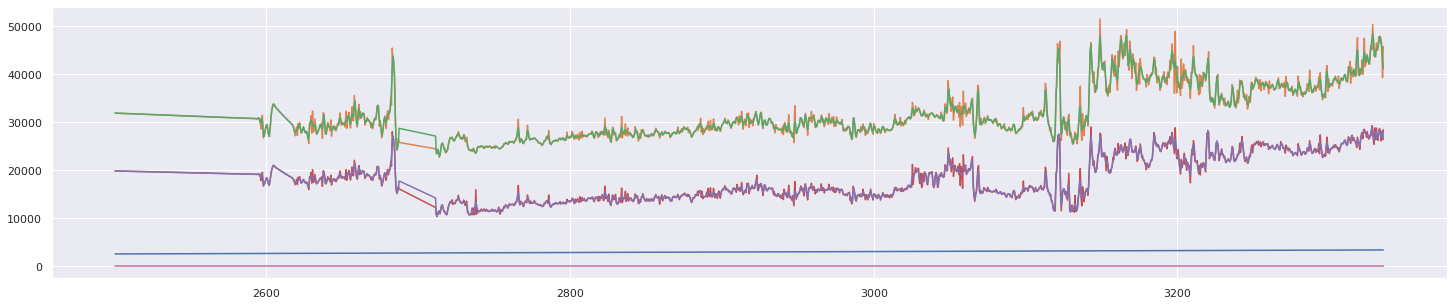

In [38]:
plt.figure(figsize=(25,5))
plt.plot(check['twt'], check[['twt', 
                              'imp_dtc_new','imp_dtc_new_filt', 
                              'imp_dts_new','imp_dts_new_filt', 
                              'rhob_new','rhob_new_filt']])

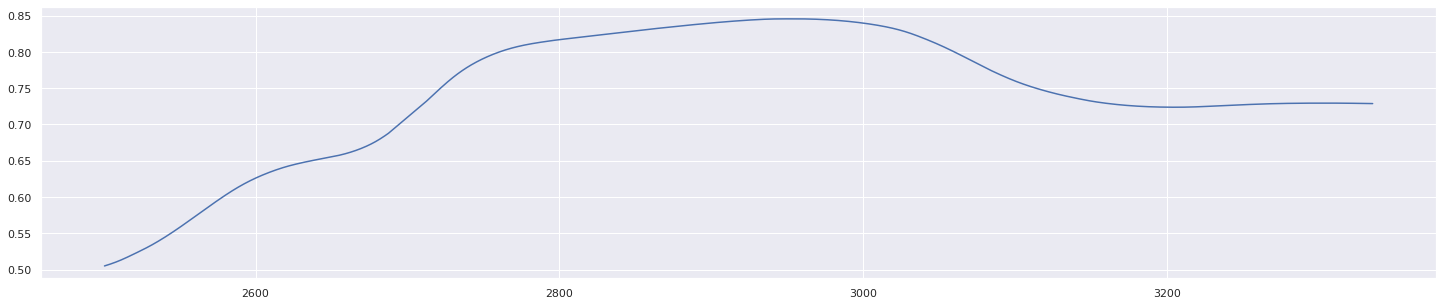

In [39]:
plt.figure(figsize=(25,5))
plt.plot(check['twt'], check[['tslowness']])

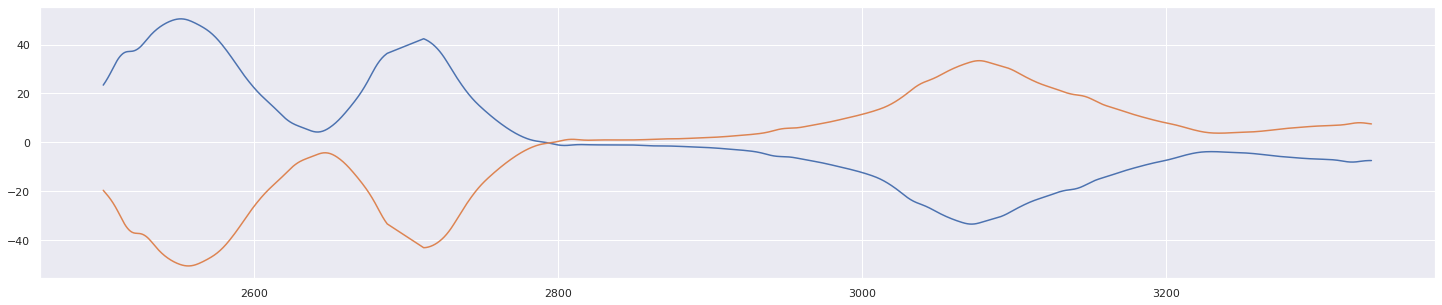

In [40]:
plt.figure(figsize=(25,5))
plt.plot(check['twt'], check[['velocity_composite_GradTrail10', 'velocity_composite_GradLead10']])

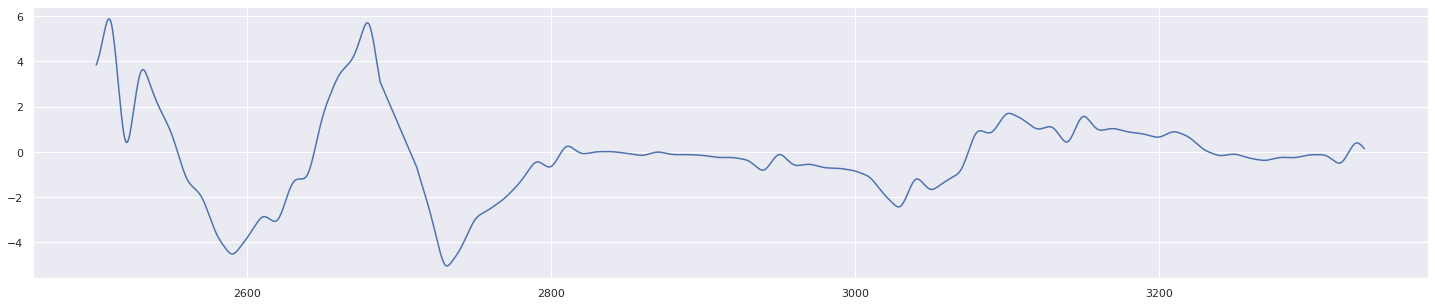

In [41]:
plt.figure(figsize=(25,5))
plt.plot(check['twt'], check[['velocity_composite_GradAcc10']])

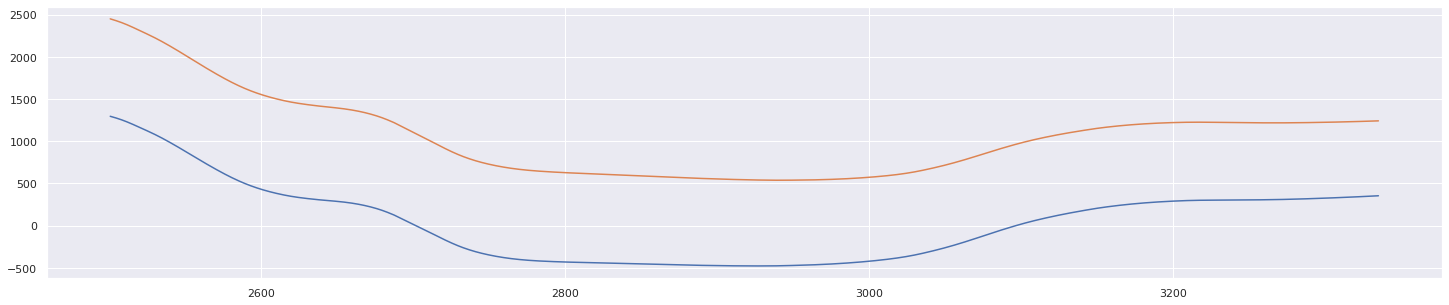

In [42]:
plt.figure(figsize=(25,5))
plt.plot(check['twt'], check[['vel_detrend', 'vel_tdetrend']])

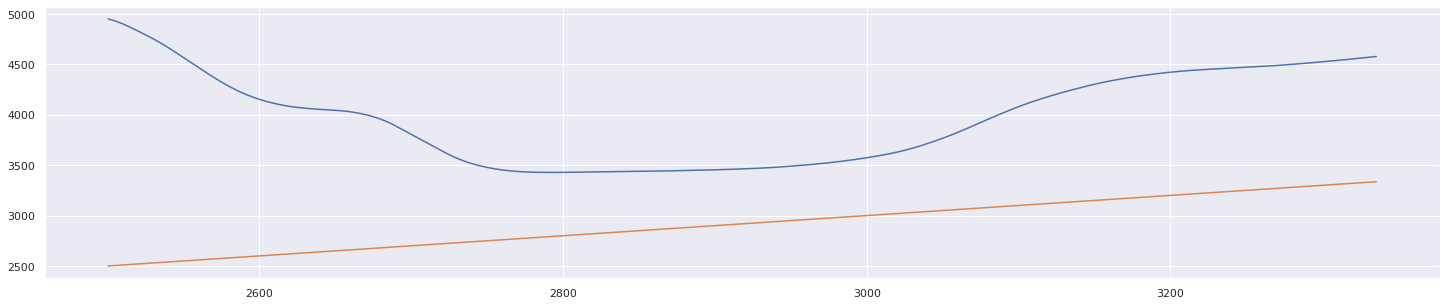

In [43]:
plt.figure(figsize=(25,5))
plt.plot(check['twt'], check[['velocity_composite', 'twt']])


We will be doing the final evaluation on completely different set of wells (2 wells).

In [44]:
from operator import itemgetter
itemgetter(5,13,25)

training_wells = itemgetter(0, 2, 4, 5, 6)(tt_independent_wells_more)
testing_well = tt_independent_wells_more[7]
blank_wells = itemgetter(1, 3)(tt_independent_wells_more)

In [45]:
print(len(tt_independent_wells_more))
wells_train = pd.concat(training_wells)
wells_test = testing_well
wells_blank = pd.concat(blank_wells)

8


In [46]:
wells_train.describe()

index           twt     rhob_new   imp_dtc_new   imp_dts_new  \
count   7887.000000  35000.000000  7887.000000   7887.000000   7887.000000   
mean    7713.042602   4250.250000     2.600494  32024.534698  17480.245085   
std     3359.274682   1010.377395     0.113852   6060.975686   4315.303716   
min     2728.000000   2500.500000     1.531400   9495.099304   7336.784131   
25%     4699.500000   3375.375000     2.528050  27869.181163  14403.584015   
50%     7511.000000   4250.250000     2.587855  30867.713453  16662.554864   
75%    10508.500000   5125.125000     2.695450  35082.205239  19767.265499   
max    13484.000000   6000.000000     3.446700  54254.260984  35277.535475   

       imp_dtc_new_log  imp_dts_new_log  rhob_new_log  near_composite_trace  \
count      7887.000000      7887.000000   7887.000000          35000.000000   
mean         10.357393         9.738866      0.954713             30.395737   
std           0.181642         0.245090      0.044877           9340.617760   
min           9.158531         8.900656      0.426182         -82279.442265   
25%          10.235277         9.575232      0.927448          -3125.462262   
50%          10.337466         9.720919      0.950829             -1.597808   
75%          10.465449         9.891783      0.991565           3037.716079   
max          10.901437        10.471002      1.237417          92785.367353   

       near_composite_trace_refl  ...  far_HTEnvCosPhs  imp_dtc_new_filt  \
count               3.500000e+04  ...     35000.000000      35000.000000   
mean               -1.035153e+01  ...        12.505421      33831.264746   
std                 2.048845e+05  ...      5462.512858       3736.133758   
min                -2.033947e+06  ...    -45949.508726      10969.483633   
25%                -3.464457e+04  ...       -37.902421      30522.493729   
50%                 1.382327e+03  ...        -1.273305      35709.974754   
75%                 3.444739e+04  ...        33.814298      35873.410249   
max                 1.957190e+06  ...     43118.579496      53815.211864   

       imp_dts_new_filt  rhob_new_filt     tslowness   vel_detrend  \
count      35000.000000   35000.000000  35000.000000  35000.000000   
mean       18550.427197       2.613118      0.882358    -44.993664   
std         2915.528897       0.074010      0.137911    377.618188   
min         7323.904288       1.483091      0.505151   -832.205293   
25%        16356.613180       2.581804      0.787777   -355.457892   
50%        19094.934245       2.606871      0.869098      0.845530   
75%        20776.482110       2.608594      0.987301    226.756129   
max        32857.091821       3.272487      1.175449   1295.696496   

       vel_tdetrend  velocity_composite_GradTrail10  \
count  35000.000000                    34950.000000   
mean     520.151167                       -0.969222   
std      639.083524                        9.357423   
min     -895.567794                      -33.401419   
25%       65.874430                       -2.164919   
50%      589.759068                       -1.115104   
75%      950.966051                       -0.006267   
max     2449.504357                       50.504433   

       velocity_composite_GradLead10  velocity_composite_GradAcc10  
count                   35000.000000                  34950.000000  
mean                        0.945716                     -0.022150  
std                         9.396104                      0.948766  
min                       -50.504433                    -10.294151  
25%                         0.006101                     -0.059463  
50%                         1.114277                     -0.000791  
75%                         2.164525                      0.059821  
max                        33.401419                      8.376441  

[8 rows x 54 columns]

In [47]:
wells_test.describe()

index          twt    rhob_new   imp_dtc_new   imp_dts_new  \
count    643.000000  7000.000000  643.000000    643.000000    643.000000   
mean   13806.000000  4250.250000    2.572848  33557.700591  18651.948193   
std      185.762393  1010.435137    0.136982   6115.506457   4376.160323   
min    13485.000000  2500.500000    1.442600  20231.575436  10585.339069   
25%    13645.500000  3375.375000    2.532271  28405.960815  14671.788056   
50%    13806.000000  4250.250000    2.580771  31198.943297  17434.593558   
75%    13966.500000  5125.125000    2.652939  38524.356405  22669.020607   
max    14127.000000  6000.000000    2.915000  52354.024672  28782.465449   

       imp_dtc_new_log  imp_dts_new_log  rhob_new_log  near_composite_trace  \
count       643.000000       643.000000    643.000000           7000.000000   
mean         10.405126         9.806758      0.943411             22.938745   
std           0.176737         0.231299      0.058665           8540.399594   
min           9.915000         9.267225      0.366447         -43964.258354   
25%          10.254354         9.593682      0.929117          -2750.752092   
50%          10.348140         9.766212      0.948088             -1.578084   
75%          10.559046        10.028753      0.975668           2917.885018   
max          10.865784        10.267522      1.069870         105502.414064   

       near_composite_trace_refl  ...  far_HTEnvCosPhs  imp_dtc_new_filt  \
count               7.000000e+03  ...      7000.000000       7000.000000   
mean                9.320397e+03  ...        17.576434      33557.700591   
std                 6.223744e+05  ...      6111.919497       1806.246022   
min                -6.065928e+06  ...    -31064.349968      22486.246859   
25%                -8.875557e+04  ...       -56.929766      33557.700591   
50%                 1.103617e+04  ...        -1.948230      33557.700591   
75%                 9.465661e+04  ...        10.156968      33557.700591   
max                 7.212953e+06  ...     48085.457905      50441.719285   

       imp_dts_new_filt  rhob_new_filt    tslowness  vel_detrend  \
count       7000.000000    7000.000000  7000.000000  7000.000000   
mean       18651.948193       2.572848     0.883297   -71.254783   
std         1307.830771       0.038270     0.120735   328.986646   
min        11432.016226       1.635012     0.561681  -745.750164   
25%        18651.948193       2.572848     0.788681  -388.737534   
50%        18651.948193       2.572848     0.855647    -2.593011   
75%        18651.948193       2.572848     0.975344   228.310956   
max        27256.545653       2.875889     1.136093   816.485331   

       vel_tdetrend  velocity_composite_GradTrail10  \
count   7000.000000                     6990.000000   
mean     509.663448                       -1.223999   
std      549.877996                        9.009565   
min     -718.743571                      -25.914071   
25%      129.561987                       -2.677953   
50%      592.305599                       -1.300016   
75%      972.803148                       -0.011425   
max     1951.315199                       58.026519   

       velocity_composite_GradLead10  velocity_composite_GradAcc10  
count                    7000.000000                   6990.000000  
mean                        1.139534                     -0.082841  
std                         9.275988                      0.922649  
min                       -58.067292                     -6.195039  
25%                         0.011290                     -0.045969  
50%                         1.296568                     -0.000360  
75%                         2.677145                      0.057607  
max                        25.914071                      5.729538  

[8 rows x 54 columns]

In [48]:
wells_blank.describe()

index  rhob_new  imp_dtc_new  imp_dts_new  imp_dtc_new_log  \
count    0.0       0.0          0.0          0.0              0.0   
mean     NaN       NaN          NaN          NaN              NaN   
std      NaN       NaN          NaN          NaN              NaN   
min      NaN       NaN          NaN          NaN              NaN   
25%      NaN       NaN          NaN          NaN              NaN   
50%      NaN       NaN          NaN          NaN              NaN   
75%      NaN       NaN          NaN          NaN              NaN   
max      NaN       NaN          NaN          NaN              NaN   

       imp_dts_new_log  rhob_new_log  near_composite_trace  \
count              0.0           0.0          14000.000000   
mean               NaN           NaN             -4.830226   
std                NaN           NaN           8910.517531   
min                NaN           NaN         -55131.058836   
25%                NaN           NaN          -3161.002771   
50%                NaN           NaN             -1.837291   
75%                NaN           NaN           3465.734707   
max                NaN           NaN          67140.278019   

       near_composite_trace_refl           twt  ...  far_HTEnvCosPhs  \
count               1.400000e+04  14000.000000  ...     14000.000000   
mean                1.155378e+03   4250.250000  ...        -8.597441   
std                 1.210769e+05   1010.399047  ...      4746.614047   
min                -8.584056e+05   2500.500000  ...    -24867.356133   
25%                -1.483645e+04   3375.375000  ...       -32.799715   
50%                 2.840397e+03   4250.250000  ...        -1.478535   
75%                 2.028358e+04   5125.125000  ...        85.397059   
max                 1.533821e+06   6000.000000  ...     27892.932069   

       imp_dtc_new_filt  imp_dts_new_filt  rhob_new_filt     tslowness  \
count               0.0               0.0            0.0  14000.000000   
mean                NaN               NaN            NaN      0.883083   
std                 NaN               NaN            NaN      0.140288   
min                 NaN               NaN            NaN      0.561739   
25%                 NaN               NaN            NaN      0.775756   
50%                 NaN               NaN            NaN      0.866855   
75%                 NaN               NaN            NaN      0.993243   
max                 NaN               NaN            NaN      1.168287   

        vel_detrend  vel_tdetrend  velocity_composite_GradTrail10  \
count  14000.000000  14000.000000                    13980.000000   
mean     -39.676589    516.525509                       -1.104851   
std      380.353716    649.385681                        9.141797   
min     -863.419559   -864.274171                      -29.981484   
25%     -358.792871     34.792165                       -1.771701   
50%      -19.480099    588.327070                       -0.880242   
75%      285.834482   1042.401173                       -0.002485   
max      808.804079   1950.856314                       49.719854   

       velocity_composite_GradLead10  velocity_composite_GradAcc10  
count                   14000.000000                  13980.000000  
mean                        1.039789                     -0.063537  
std                         9.298039                      1.016952  
min                       -50.127361                     -6.944699  
25%                         0.002265                     -0.070439  
50%                         0.876216                     -0.002386  
75%                         1.770575                      0.050606  
max                        29.981484                      7.174633  

[8 rows x 54 columns]

8
7887 643 8530


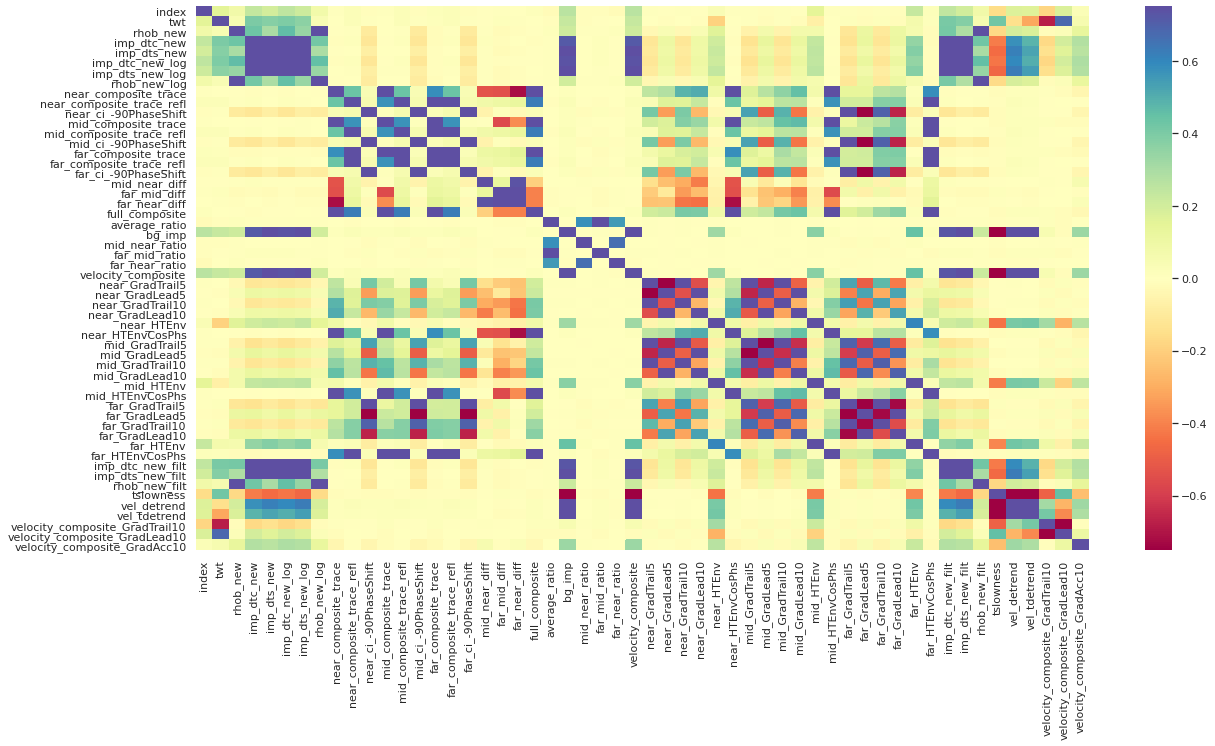

In [49]:
print(len(tt_independent_wells_more))
wells_train = pd.concat(training_wells)
wells_test = testing_well
wells_blank = pd.concat(blank_wells)

wells_train_nonan = wells_train.dropna()
wells_test_nonan = wells_test.dropna()
wells_data = pd.concat([wells_train_nonan, wells_test_nonan])

print(len(wells_train_nonan), len(wells_test_nonan), len(wells_data))
def get_corr_map(df, colmap):
    
    # calculate the correlation matrix - Public
    corr = df.corr()

    # plot the heatmap
    plt.figure(figsize=(20,10))
    sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, vmin=-0.75, vmax=0.75, center= 0, annot = False, cmap=colmap)

get_corr_map(wells_data, 'Spectral')

In [50]:
features = ['twt','near_composite_trace', 'near_composite_trace_refl',
       'near_ci_-90PhaseShift', 'mid_composite_trace',
       'mid_composite_trace_refl', 'mid_ci_-90PhaseShift',
       'far_composite_trace', 'far_composite_trace_refl',
       'far_ci_-90PhaseShift', 'mid_near_diff', 'far_mid_diff',
       'far_near_diff', 'full_composite', 'average_ratio',
       'mid_near_ratio', 'far_mid_ratio', 'far_near_ratio', 'near_GradTrail5',
       'near_GradLead5', 'near_GradTrail10', 'near_GradLead10', 'near_HTEnv',
       'near_HTEnvCosPhs', 'mid_GradTrail5', 'mid_GradLead5',
       'mid_GradTrail10', 'mid_GradLead10', 'mid_HTEnv', 'mid_HTEnvCosPhs',
       'far_GradTrail5', 'far_GradLead5', 'far_GradTrail10', 'far_GradLead10',
       'far_HTEnv', 'far_HTEnvCosPhs', 'velocity_composite','tslowness',
       'vel_detrend', 'vel_tdetrend', 'velocity_composite_GradTrail10',
       'velocity_composite_GradLead10', 'velocity_composite_GradAcc10']

targets = ['imp_dtc_new_filt', 'imp_dts_new_filt', 'rhob_new_filt']

targets_twt = ['imp_dtc_new_filt', 'imp_dts_new_filt', 'rhob_new_filt', 'twt']

In [51]:
wells_data = pd.DataFrame(wells_data.values, index=wells_data['twt'], columns=wells_data.columns)
#wells_data.set_index('twt')
#wells_data_new = wells_data.dropna()
X_data = wells_data[features]
y_data = wells_data[targets]

wells_blank_nonan = wells_blank
wells_blank_nonan[targets] = wells_blank_nonan[targets].fillna(-999)
dp_col = ['imp_dtc_new', 'imp_dts_new', 'rhob_new','imp_dtc_new_log', 'imp_dts_new_log', 'rhob_new_log','index']
wells_blank_nonan = wells_blank_nonan.drop(dp_col, axis=1)
wells_blank_nonan = wells_blank_nonan.dropna()
print(len(wells_blank_nonan))
X_blank = wells_blank_nonan[features]
y_blank = wells_blank_nonan[targets_twt]

print(len(X_data))

X_blank.head()
#print(wells_blank_nonan.columns)

13980
8530


twt  near_composite_trace  near_composite_trace_refl  \
5001  2500.5          -7182.209358               37308.111248   
5002  2501.0          -2997.550535               71560.160888   
5003  2501.5           1483.965525              106011.491958   
5004  2502.0           6120.955291              139214.015211   
5005  2502.5          10772.035233              169719.641397   

      near_ci_-90PhaseShift  mid_composite_trace  mid_composite_trace_refl  \
5001           -4848.766008         11767.782541              37308.111248   
5002           -4533.499540         14246.667471              71560.160888   
5003           -4058.465866         16583.270278             106011.491958   
5004           -3424.167451         18728.863436             139214.015211   
5005           -2639.185882         20634.719417             169719.641397   

      mid_ci_-90PhaseShift  far_composite_trace  far_composite_trace_refl  \
5001          -4848.766008         11327.704052              37308.111248   
5002          -4533.499540         12443.346927              71560.160888   
5003          -4058.465866         13482.765214             106011.491958   
5004          -3424.167451         14413.711597             139214.015211   
5005          -2639.185882         15203.938758             169719.641397   

      far_ci_-90PhaseShift  ...  far_GradLead10     far_HTEnv  \
5001          -4848.766008  ...     8553.539005  11917.963616   
5002          -4533.499540  ...     9470.894599  12785.962421   
5003          -4058.465866  ...    10092.056936  13626.292679   
5004          -3424.167451  ...    10407.576189  14436.431078   
5005          -2639.185882  ...    10415.048059  15213.347092   

      far_HTEnvCosPhs  velocity_composite  tslowness  vel_detrend  \
5001     11327.704052         4425.448532   0.565027   808.804079   
5002     12443.346927         4421.519840   0.565643   804.558376   
5003     13482.765214         4417.574995   0.566261   800.296520   
5004     14413.711597         4413.614525   0.566882   796.019038   
5005     15203.938758         4409.638953   0.567507   791.726455   

      vel_tdetrend  velocity_composite_GradTrail10  \
5001   1924.948532                       39.950679   
5002   1920.519840                       40.088542   
5003   1916.074995                       40.221147   
5004   1911.614525                       40.348495   
5005   1907.138953                       40.470585   

      velocity_composite_GradLead10  velocity_composite_GradAcc10  
5001                     -38.265138                      1.685540  
5002                     -38.460859                      1.627683  
5003                     -38.650153                      1.570994  
5004                     -38.833168                      1.515327  
5005                     -39.010049                      1.460536  

[5 rows x 43 columns]

In [52]:
def minmax_scaler(data, minmaxrange=(-1,1)):
    scaler = MinMaxScaler(feature_range = minmaxrange)
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def SS_scaler(data, minmaxrange=(-1,1)):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

In [53]:
X_data_scaled, X_scaler = SS_scaler(X_data, minmaxrange=(-1,1))
y_data_scaled, y_scaler = SS_scaler(y_data, minmaxrange=(-1,1))

X_blank_scaled = X_scaler.transform(X_blank)


print(len(X_data_scaled))

8530


17


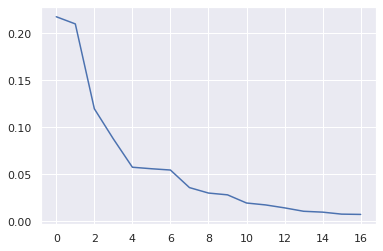

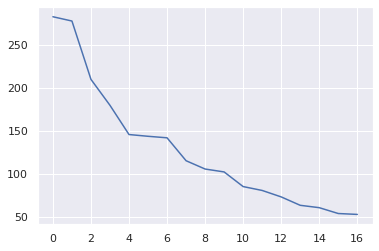

In [54]:
from sklearn.decomposition import PCA
num_p = int(len(X_data.columns)*0.4)

X_data_scaled = pd.DataFrame(X_data_scaled, columns=X_data.columns, index=X_data.index)
X_blank_scaled = pd.DataFrame(X_blank_scaled, columns=X_blank.columns, index=X_blank.index)

print(num_p)
pca = PCA(n_components=num_p)
pca.fit(X_data_scaled)
plt.figure()
plt.plot(pca.explained_variance_ratio_)

plt.figure()
plt.plot(pca.singular_values_)

In [55]:
X_data_scaled = pca.transform(X_data_scaled)
X_blank_scaled = pca.transform(X_blank_scaled)
col_p = []
for i in range(num_p):
    col_p.append('P_' + str(i))
print(col_p)

X_data_scaled = pd.DataFrame(X_data_scaled, columns=col_p, index=X_data.index)

print(len(X_data_scaled))
X_data_scaled.head()

['P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'P_6', 'P_7', 'P_8', 'P_9', 'P_10', 'P_11', 'P_12', 'P_13', 'P_14', 'P_15', 'P_16']
8530


P_0       P_1       P_2       P_3       P_4       P_5       P_6  \
twt                                                                            
2500.5  5.608775  2.160220  5.771199 -1.733353 -0.517502  1.106653 -0.446530   
2501.0  5.306293  2.692734  5.777548 -1.937621 -0.511854  0.970880 -0.374625   
2501.5  4.950620  3.165973  5.790323 -2.130888 -0.495366  0.794484 -0.280396   
2502.0  4.551244  3.580011  5.808196 -2.303032 -0.468847  0.579671 -0.165383   
2502.5  4.119614  3.934120  5.829692 -2.443359 -0.434071  0.332764 -0.033194   

             P_7       P_8       P_9      P_10      P_11      P_12      P_13  \
twt                                                                            
2500.5 -2.481105  0.017692  0.930233  1.580181  0.161554 -0.197269  0.537087   
2501.0 -2.486228  0.011519  0.975726  1.617638  0.100925 -0.267429  0.507769   
2501.5 -2.487262  0.007480  1.005272  1.652243  0.014218 -0.325625  0.475652   
2502.0 -2.484906  0.005484  1.017437  1.686375 -0.090661 -0.368690  0.441112   
2502.5 -2.479908  0.005267  1.012770  1.721906 -0.206214 -0.394772  0.404539   

            P_14      P_15      P_16  
twt                                   
2500.5  0.014945 -0.043595  0.354371  
2501.0  0.098147 -0.029738  0.324805  
2501.5  0.165019 -0.016464  0.293859  
2502.0  0.213967 -0.004149  0.263793  
2502.5  0.243595  0.006509  0.237137

In [56]:
X_train_scaled = X_data_scaled.iloc[:len(wells_train_nonan)]
X_test_scaled = X_data_scaled.iloc[len(wells_train_nonan):]


print(len(X_train_scaled), len(X_test_scaled))

y_data_scaled = pd.DataFrame(y_data_scaled, columns=y_data.columns, index=X_data.index)
y_train_scaled = y_data_scaled.iloc[:len(wells_train_nonan)]
y_test_scaled = y_data_scaled.iloc[len(wells_train_nonan):]


7887 643


In [57]:
print(len(X_train_scaled), len(X_data_scaled), len(wells_train_nonan))
X_train_scaled.head()

7887 8530 7887


P_0       P_1       P_2       P_3       P_4       P_5       P_6  \
twt                                                                            
2500.5  5.608775  2.160220  5.771199 -1.733353 -0.517502  1.106653 -0.446530   
2501.0  5.306293  2.692734  5.777548 -1.937621 -0.511854  0.970880 -0.374625   
2501.5  4.950620  3.165973  5.790323 -2.130888 -0.495366  0.794484 -0.280396   
2502.0  4.551244  3.580011  5.808196 -2.303032 -0.468847  0.579671 -0.165383   
2502.5  4.119614  3.934120  5.829692 -2.443359 -0.434071  0.332764 -0.033194   

             P_7       P_8       P_9      P_10      P_11      P_12      P_13  \
twt                                                                            
2500.5 -2.481105  0.017692  0.930233  1.580181  0.161554 -0.197269  0.537087   
2501.0 -2.486228  0.011519  0.975726  1.617638  0.100925 -0.267429  0.507769   
2501.5 -2.487262  0.007480  1.005272  1.652243  0.014218 -0.325625  0.475652   
2502.0 -2.484906  0.005484  1.017437  1.686375 -0.090661 -0.368690  0.441112   
2502.5 -2.479908  0.005267  1.012770  1.721906 -0.206214 -0.394772  0.404539   

            P_14      P_15      P_16  
twt                                   
2500.5  0.014945 -0.043595  0.354371  
2501.0  0.098147 -0.029738  0.324805  
2501.5  0.165019 -0.016464  0.293859  
2502.0  0.213967 -0.004149  0.263793  
2502.5  0.243595  0.006509  0.237137

In [58]:
## Here we shuffle the data
#print(len(y_train_scaled), len(X_train_scaled))
#training_wells_tt = pd.concat([X_train_scaled, y_train_scaled], axis=1) #X_train.join(y_train)
##print(len(training_wells_tt), len(X_train))
#training_wells_tt = training_wells_tt.dropna()
#training_wells_tt = training_wells_tt.sample(frac=1)
#training_wells_tt.head()

In [59]:
## Here we seperate into inputs and targets 
#X_train_scaled = training_wells_tt[X_data_scaled.columns]
#y_train_scaled = training_wells_tt[targets]
#
#X_test_scaled = training_wells_tt[X_data_scaled.columns]
#y_test_scaled = training_wells_tt[targets]
# Here we scale the training inputs and create the scaler to be used to scale testing data and for inverse transform after simulation
#X_train_scaled, X_scaler = minmax_scaler(X_train, minmaxrange=(-1,1))
#X_train_scaled, X_scaler = SS_scaler(X_train, minmaxrange=(-1,1))
#X_test_scaled = X_scaler.transform(X_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
#X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
#X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)


# Here we do the same for the targets
#y_train_scaled, y_scaler = minmax_scaler(y_train, minmaxrange=(-1,1))
#y_train_scaled, y_scaler = SS_scaler(y_train, minmaxrange=(-1,1))
#y_test_scaled = y_scaler.transform(y_test)

# Print for QC
print('training inputs:', X_train_scaled)
print('training targets:',y_train_scaled)

training inputs:              P_0       P_1       P_2       P_3       P_4       P_5       P_6  \
twt                                                                            
2500.5  5.608775  2.160220  5.771199 -1.733353 -0.517502  1.106653 -0.446530   
2501.0  5.306293  2.692734  5.777548 -1.937621 -0.511854  0.970880 -0.374625   
2501.5  4.950620  3.165973  5.790323 -2.130888 -0.495366  0.794484 -0.280396   
2502.0  4.551244  3.580011  5.808196 -2.303032 -0.468847  0.579671 -0.165383   
2502.5  4.119614  3.934120  5.829692 -2.443359 -0.434071  0.332764 -0.033194   
...          ...       ...       ...       ...       ...       ...       ...   
3384.0 -2.121718  0.879551  1.331001 -0.483824  1.887751  1.009428 -0.546582   
3384.5 -2.300241  0.735257  1.375633 -0.450326  1.901785  1.009996 -0.544243   
3385.0 -2.467003  0.563114  1.419686 -0.414039  1.915662  1.008829 -0.538061   
3385.5 -2.617919  0.366927  1.462553 -0.375586  1.929466  1.007997 -0.524766   
3386.0 -2.749817  0.150

In [60]:
features = col_p
features

['P_0',
 'P_1',
 'P_2',
 'P_3',
 'P_4',
 'P_5',
 'P_6',
 'P_7',
 'P_8',
 'P_9',
 'P_10',
 'P_11',
 'P_12',
 'P_13',
 'P_14',
 'P_15',
 'P_16']

In [61]:
y_train_scaled.head()

imp_dtc_new_filt  imp_dts_new_filt  rhob_new_filt
twt                                                      
2500.5         -0.052350          0.518191      -0.065674
2501.0         -0.053423          0.517278      -0.066031
2501.5         -0.054496          0.516366      -0.066387
2502.0         -0.055569          0.515454      -0.066744
2502.5         -0.056642          0.514542      -0.067101

### Neural Network Model Training

The model below is a Sequential Model: A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. Learn more about Sequential Models here: https://keras.io/guides/sequential_model/

**Architecture:**
- 8 input Neurons 
- 2 Hidden Layers w/ 32 neurons each 
- 3 Outputs 

**Hyperparameters:**
- Hidden Layer has ReLu Activation
- Output Layer has Linear Activation
- Adam Optimizer
- MSE as loss metric 
- EarlyStopping is active w/ Patience = 30 
- Batch Size is 256 
- 50% of data is reserved for validation 
- Training with a MAX of 5000 Epochs

In [ ]:
# %%time
# Train models and keep them in memory 
# This is where we define the amount of models in the ensemble
# We save those models to a list 'models'
n_members = 5
model_store = []

# We store our training performance in 'history_store'
history_store = []

accuracy_store = []
#here we define model architecture and train the neural network in a loop for each model 
for i in range(n_members): 
    model = Sequential()
    
    # Adding layers
    model.add(layers.Dense(8, activation='relu', input_dim=X_train_scaled.shape[1], kernel_regularizer=k.regularizers.l1_l2(0.005),  kernel_initializer='he_uniform'))
    model.add(layers.Dense(8, activation='relu', kernel_regularizer=k.regularizers.l1_l2(0.005), kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization())
    #model.add(Dropout(rate=0.25))
    model.add(layers.Dense(16, activation='relu', kernel_regularizer=k.regularizers.l1_l2(0.005), kernel_initializer='he_uniform'))
    model.add(layers.Dense(16, activation='relu', kernel_regularizer=k.regularizers.l1_l2(0.005), kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=k.regularizers.l1_l2(0.005), kernel_initializer='he_uniform'))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=k.regularizers.l1_l2(0.005), kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=k.regularizers.l1_l2(0.005), kernel_initializer='he_uniform'))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=k.regularizers.l1_l2(0.005), kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization())
    #model.add(layers.Dense(96, activation='relu', kernel_initializer='he_uniform'))
    #model.add(layers.Dense(96, activation='relu', kernel_initializer='he_uniform'))
    #model.add(layers.BatchNormalization())
    #model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    #model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    #model.add(layers.BatchNormalization())
    #model.add(layers.Dense(8, activation='relu', kernel_initializer='he_uniform'))

    model.add(layers.Dense(y_train_scaled.shape[1], activation='linear'))
    
    # Setting optimizer
    opt = keras.optimizers.Adam(learning_rate=0.001)
    
    # Compile model and add callbacks
    model.compile(optimizer=opt, loss='mse')
    callbacks = [k.callbacks.EarlyStopping(monitor='loss', patience=30)]
    
    # Fit and save! 
    history_store.append(model.fit(X_train_scaled, 
                                   y_train_scaled, 
                                   epochs=5000, validation_split=0.5,
                                   shuffle=True, batch_size=256, callbacks=callbacks,
                                   verbose=0))
    accuracy = model.evaluate(X_train_scaled, y_train_scaled)
    accuracy_store.append(accuracy)
    
    model_store.append(model)
    
    # Some basic print statements for updating us during training
    loss = history_store[i].history['loss']
    epochs = range(len(loss))
    print('-------------------------------------------------- Completed Training of Model #', i)
    print('-------------------------------------------------- Total Epochs Range:', epochs )
    print('-----------------------------------------------------------------------------------')

7887/7887 [==============================] - 3s 369us/sample - loss: 0.8393
-------------------------------------------------- Completed Training of Model # 0
-------------------------------------------------- Total Epochs Range: range(0, 513)
-----------------------------------------------------------------------------------


Visualize the training metrics - loss and validation loss functions

In [ ]:
for history in history_store:
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure(figsize=(25,5))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.legend(loc='upper left')
    plt.title(str(history))

## Bootstrap Aggregation and Inference

In [ ]:
yhats = [y_scaler.inverse_transform(model.predict(X_test_scaled)) for model in model_store]
yhats = np.array(yhats)

y_test = y_scaler.inverse_transform(y_test_scaled)
y_test = pd.DataFrame(y_test, columns=y_test_scaled.columns, index=y_test_scaled.index)

Zp_ensemble = yhats[:,:,0].mean(0)
Zs_ensemble = yhats[:,:,1].mean(0)
Rhob_ensemble = yhats[:,:,2].mean(0)

Results = y_test.copy()
Results['Zp_Prediction'] = Zp_ensemble
Results['Zs_Prediction'] = Zs_ensemble
Results['Rhob_Prediction'] = Rhob_ensemble
#Results['twt'] = X_test_scaled.index
Results = Results.reset_index()
Results.head()

In [ ]:
plt.plot(Results['twt'])

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(311)
plt.plot(Results['twt'],Results[['Zp_Prediction','imp_dtc_new_filt']])
plt.legend(loc='upper left', labels =['Zp_Prediction','imp_dtc_new_filt'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zp')
plt.subplot(312)
plt.plot(Results['twt'],Results[['Zs_Prediction','imp_dts_new_filt']])
plt.legend(loc='upper left', labels =['Zs_Prediction','imp_dts_new_filt'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zs')
plt.subplot(313)
plt.plot(Results['twt'],Results[['Rhob_Prediction','rhob_new_filt']])
plt.legend(loc='upper left', labels =['Rhob_Prediction','rhob_new_filt'])
plt.xlabel('twt (ms) ')
plt.ylabel('Rhob')
plt.show();

In [ ]:
## evaluate the keras model
for accuracy in accuracy_store:
    print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
nrmse = {}

nrmse['Zp'] = np.sqrt(mean_squared_error(Results['imp_dtc_new_filt'], Results['Zp_Prediction'])) / np.mean(Results['imp_dtc_new_filt'])
nrmse['Zs'] = np.sqrt(mean_squared_error(Results['imp_dts_new_filt'], Results['Zs_Prediction'])) / np.mean(Results['imp_dts_new_filt'])
nrmse['Rhob'] = np.sqrt(mean_squared_error(Results['rhob_new_filt'], Results['Rhob_Prediction'])) / np.mean(Results['rhob_new_filt'])

### Compute score and loss and compare against test data
print("NRSME for Zp: {}".format(nrmse['Zp']))
print("NRSME for Zs: {}".format(nrmse['Zs']))
print("NRSME for Rhob: {}".format(nrmse['Rhob']))

plt.figure(figsize=(5,5))
plt.plot(np.linspace(10000,50000,10),np.linspace(10000,50000,10),'-k')
plt.scatter(Results['imp_dtc_new_filt'], Results['Zp_Prediction'], s=2)
plt.xlabel('test');plt.ylabel('prediction'),plt.title('Zp (Predictied vs Test)')
plt.grid(); plt.xlim(10000,50000);plt.ylim(10000,50000)


plt.figure(figsize=(5,5))
plt.plot(np.linspace(10000,30000,10),np.linspace(10000,30000,10),'-k')
plt.scatter(Results['imp_dts_new_filt'], Results['Zs_Prediction'], s=2)
plt.xlabel('test');plt.ylabel('prediction'),plt.title('Zs (Predictied vs Test)')
plt.grid(); plt.xlim(10000,30000);plt.ylim(10000,30000)


plt.figure(figsize=(5,5))
plt.plot(np.linspace(2,3.2,10),np.linspace(2,3.2,10),'-k')
plt.scatter(Results['rhob_new_filt'], Results['Rhob_Prediction'], s=2)
plt.xlabel('test');plt.ylabel('prediction'),plt.title('Rhob (Predictied vs Test)')
plt.grid(); plt.xlim(2,3.2);plt.ylim(2,3.2)

In [ ]:
MAE_store = []
R2_store = []
from sklearn.metrics import r2_score
### PREDICTION ERROR ON TEST DATA ###
for model in model_store:
    real_pred = y_scaler.inverse_transform(model.predict(X_test_scaled))
    MAE = mean_absolute_error(y_test, real_pred)
    MAE_store.append(MAE)

    R2= r2_score(y_true=y_test,
                         y_pred=real_pred,
                )
                         #multioutput='variance_weighted',
                         #)
    R2_store.append(R2)
    
MAE_store = np.asarray(MAE_store)
R2_store = np.asarray(R2_store)
print(MAE_store)
print(R2_store)

## Blank wells

In [ ]:

yhats_blank = [y_scaler.inverse_transform(model.predict(X_blank_scaled)) for model in model_store]
yhats_blank = np.array(yhats_blank)

Zp_ensemble_blank = yhats_blank[:,:,0].mean(0)
Zs_ensemble_blank = yhats_blank[:,:,1].mean(0)
Rhob_ensemble_blank = yhats_blank[:,:,2].mean(0)


#X_blank_label = X_blank_scaled
Results_blank = y_blank.copy()
Results_blank['Zp_Prediction'] = Zp_ensemble_blank
Results_blank['Zs_Prediction'] = Zs_ensemble_blank
Results_blank['Rhob_Prediction'] = Rhob_ensemble_blank
Results_blank['twt'] = y_blank['twt']
Results_blank = Results_blank.reset_index()
Results_blank.head()

In [ ]:
Results_blank.iloc[:7000].head()

In [ ]:
Results_blank.iloc[7000:].head()

In [ ]:
well_df_blk.head()

In [ ]:
my_result = Results_blank[['Zp_Prediction', 'Zs_Prediction', 'Rhob_Prediction', 'twt']].copy()
my_result.rename(columns={'Zp_Prediction': "p_impedance"}, inplace=True)
my_result.rename(columns={'Zs_Prediction': "s_impedance"}, inplace=True)
my_result.rename(columns={'Rhob_Prediction': "rhob"}, inplace=True)
my_result['well_id'] = ''
my_result['well_id'].iloc[:7000] = 'well_07'
my_result['well_id'].iloc[7000:] = 'well_13'

my_result.set_index(['well_id', 'twt'], inplace=True)
my_result = my_result.merge(well_df_blk, on=['well_id', 'twt'])
my_result.rename(columns={'p_impedance_x': "p_impedance"}, inplace=True)
my_result.rename(columns={'s_impedance_x': "s_impedance"}, inplace=True)
my_result.rename(columns={'rhob_x': "rhob"}, inplace=True)
my_result = my_result.drop(['rhob_y','p_impedance_y','s_impedance_y'], axis=1)
my_result.head()

In [ ]:
for well in well_df_blk.index.levels[0]:
    well_df_blk.loc[well].head()
    
well_df_blk.loc[well].head()

In [ ]:
my_result.loc[well].head()

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(my_result.iloc[0].index.values, my_result.iloc[0][['p_impedance', 's_impedance', 'rhob']])

In [ ]:
"""
bucket = 's3://sagemaker-gitc2021/poseidon/wells/submissions/intermediate/'

file_name = 'TeamKT_Intermediate06_Results_20210425.json'

# Making sure extension is in the file name.
if not file_name.lower().endswith('.json'):
    file_name += '.json'

my_result.reset_index(inplace=True)
my_result.to_json(
    path_or_buf=bucket + file_name,
    double_precision=4,
)
"""

In [ ]:
"""
file_name = 'TeamKT_Intermediate06_Results_20210425.json'
my_result.to_csv(path_or_buf=file_name, index=False)
"""

In [ ]:
#import pickle
#from joblib import dump, load
#filename = 'Intmed_1_7234.sav'
##pickle.dump(model_store, open(filename, 'wb'))
#dump(model_store, filename)
"""

# serialize model to JSON
for i in range(len(model_store)):
    file_name = 'Intmed_7235_' + str(i)
    model_json = model_store[i].to_json()
    with open(file_name + '.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model_store[i].save_weights(file_name + '.h5')
    print("Saved model to disk")
"""

In [ ]:
### COMPUTE PERMUTATION AND SCORING ###

#os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
#random.seed(33)

final_score = []
shuff_pred = []

for i,col in enumerate(X_test_scaled.columns):

    final_score_tmp = []
    shuff_pred_tmp = []
    for model in model_store:

        # shuffle column
        shuff_test = X_test_scaled.values #.copy()
        shuff_test[:,i] = np.random.permutation(shuff_test[:,i])
    
        # compute score
        score = mean_absolute_error(y_test, y_scaler.inverse_transform(model.predict(shuff_test)))
        #print(score)
        shuff_pred_tmp.append(y_scaler.inverse_transform(model.predict(shuff_test)))
        final_score_tmp.append(score)
    
    final_score.append(np.mean(np.asarray(final_score_tmp)))
    
final_score = np.asarray(final_score)
final_score

In [ ]:
### PERMUTATION IMPORTANCE REPORT ###
#print(measure_final.shape)
measure_final = (final_score - np.mean(MAE_store))/np.mean(MAE_store)*100
df_final_score = pd.DataFrame(measure_final, index=features, columns=['final_score'])
df_final_score = df_final_score.sort_values(by=['final_score'])
df_final_score.head()

In [ ]:
plt.figure(figsize=(45,5))
plt.bar(range(X_train.shape[1]), df_final_score['final_score'].values)
plt.xticks(range(X_train.shape[1]), df_final_score['final_score'].index)
np.set_printoptions(False)

In [ ]:
df_final_score['final_score'].index

### GBR!!

In [ ]:
### Plot training history
def deviance(reg, X_test, y_test, plot=False):
    test_score = np.zeros((reg.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(reg.staged_predict(X_test)):
        test_score[i] = reg.loss_(y_test, y_pred)

    if plot == True:
        fig = plt.figure(figsize=(5, 5))
        plt.subplot(1, 1, 1)
        plt.title('Deviance')
        plt.plot(np.arange(reg.n_estimators) + 1, reg.train_score_, 'b-',label='Training loss')
        plt.plot(np.arange(reg.n_estimators) + 1, test_score, 'r-',label='Test loss')
        plt.xlabel('Boosting Iterations')
        plt.ylabel('Loss')
        plt.legend(loc='upper right'); plt.grid()
    else:
        return test_score
    
    

## Train a gradient boosting model

In [ ]:
params = {'loss': 'ls',
          'learning_rate': 0.03,
          'n_estimators': 200,
          'subsample': 0.8,
          'max_depth': 64,
          'max_features': 0.3,
          'min_impurity_decrease': 1e-10,
          'min_samples_leaf': 5
         }

print('Training...')
reg = gbr(random_state=98,**params)
reg.fit(X_train_scaled, y_train_scaled)

y_pred = reg.predict(X_test_scaled)

yhats = y_scaler.inverse_transform(y_pred)
yhats = np.array(yhats)

# Todo ?
Change model architecture?
learning rate?
shuffle or not shuffle?
gbr?
